# Data Source
- Select Dataset concluded years
- Feature drop 
    - Unique keys, redundant features
    - ratio of missing value > 95%
    - Select Feature two methods
        - select features 15~18 how to pre-train xgboost method
        - bivariate, correlation analysis
            - borrowers characteristic
            - Loan characteristic
            - credit characteristic
            - credit history 
    - Data augmentation
        - Random undersampling
        - Oversampling SMOTE-NC
        - Generation exclude based AE
    - Machig Learning Modeling
        - LR
        - xbgoost
        - LightGBM
    - Evaluation
        - G-mean score
        - K-S score
        - Confusion matrix
        - ROC - AUC

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import os

import torch

import warnings
warnings.filterwarnings("ignore") 

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [3]:
## Load lending club data 
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/loan_data.csv"
data = pd.read_csv(data_path, low_memory=False)

In [4]:
len(data.columns)

142

In [5]:
data.head()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [6]:
data_original = data.copy()

In [7]:
for col in data.columns:
    print(f"{col} features The number of NaN {data[col].isna().sum()}\n")

Unnamed: 0 features The number of NaN 0

id features The number of NaN 0

loan_amnt features The number of NaN 1

funded_amnt features The number of NaN 1

funded_amnt_inv features The number of NaN 1

term features The number of NaN 1

int_rate features The number of NaN 1

installment features The number of NaN 1

grade features The number of NaN 1

sub_grade features The number of NaN 1

emp_title features The number of NaN 264087

emp_length features The number of NaN 205221

home_ownership features The number of NaN 1

annual_inc features The number of NaN 5

verification_status features The number of NaN 1

issue_d features The number of NaN 1

loan_status features The number of NaN 1

pymnt_plan features The number of NaN 1

url features The number of NaN 1

purpose features The number of NaN 1

title features The number of NaN 23327

zip_code features The number of NaN 2

addr_state features The number of NaN 1

dti features The number of NaN 3109

delinq_2yrs features The numb

In [8]:
for col in data.columns:
    print(f"{col} value :\n{data[col].unique()}\n")

Unnamed: 0 value :
[     0      1      2 ... 421092 421093 421094]

id value :
['1077501' '1077430' '1077175' ... '102628603' '102196576' '99799684']

loan_amnt value :
[ 5000.  2500.  2400. ... 39650. 35475. 38350.]

funded_amnt value :
[ 5000.  2500.  2400. ... 39650. 35475. 38350.]

funded_amnt_inv value :
[ 4975.          2500.          2400.         ... 31496.16546498
 21595.18110536  9982.00356554]

term value :
[' 36 months' ' 60 months' nan]

int_rate value :
[' 10.65%' ' 15.27%' ' 15.96%' ' 13.49%' ' 12.69%' '  7.90%' ' 18.64%'
 ' 21.28%' ' 14.65%' '  9.91%' ' 16.29%' '  6.03%' ' 11.71%' ' 12.42%'
 ' 14.27%' ' 16.77%' '  7.51%' '  8.90%' ' 18.25%' '  6.62%' ' 19.91%'
 ' 17.27%' ' 17.58%' ' 21.67%' ' 19.42%' ' 22.06%' ' 20.89%' ' 20.30%'
 ' 23.91%' ' 19.03%' ' 23.52%' ' 23.13%' ' 22.74%' ' 22.35%' ' 24.11%'
 '  6.00%' ' 22.11%' '  7.49%' ' 11.99%' '  5.99%' ' 10.99%' '  9.99%'
 ' 18.79%' ' 11.49%' '  8.49%' ' 15.99%' ' 16.49%' '  6.99%' ' 12.99%'
 ' 15.23%' ' 14.79%' '  5.42%' 

### Data unique key feature, data leakage feature drop

In [9]:
## 20개 삭제제
##Data Leakage drop.
#feature drop

drop_data_leakage = ['total_pymnt','total_pymnt_inv','out_prncp',
                     'out_prncp_inv','recoveries','collection_recovery_fee',
                     'last_pymnt_d','last_pymnt_amnt','issue_d',
                     'next_pymnt_d','last_credit_pull_d','total_rec_prncp', 
                    'total_rec_int','total_rec_late_fee'
                     ]

data = data.drop(columns=drop_data_leakage)

print(len(data.columns))

128


In [9]:
data.describe()

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount
count,2.925493e+06,2.925492e+06,2.925492e+06,2.925492e+06,2.925492e+06,2.925488e+06,2.922384e+06,2.925463e+06,2.925492e+06,2.925492e+06,...,197824.000000,197824.000000,197824.000000,143638.000000,182076.000000,143638.000000,143637.000000,179240.000000,182076.000000,182076.000000
mean,8.697419e+04,1.535878e+04,1.535470e+04,1.534005e+04,4.523914e+02,7.993727e+04,1.929648e+01,2.897012e-01,7.005110e+02,7.045112e+02,...,12.544398,0.038327,0.067545,2.233427,119.887400,2.233427,2.323148,369.367460,11993.128927,745.504875
std,8.048842e+04,9.478383e+03,9.477145e+03,9.480634e+03,2.729478e+02,1.117476e+05,1.571977e+01,8.436819e-01,3.376565e+01,3.376653e+01,...,8.206977,0.362390,0.371836,0.565689,247.522976,0.565689,6.179453,468.696526,9162.902724,2095.316599
min,0.000000e+00,5.000000e+02,5.000000e+02,0.000000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.100000e+02,6.140000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.284100e+04,8.000000e+03,8.000000e+03,8.000000e+03,2.535000e+02,4.700000e+04,1.208000e+01,0.000000e+00,6.750000e+02,6.790000e+02,...,7.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,104.280000,4749.142500,259.040000
50%,6.892500e+04,1.300000e+04,1.300000e+04,1.300000e+04,3.823000e+02,6.600000e+04,1.810000e+01,0.000000e+00,6.950000e+02,6.990000e+02,...,11.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,249.474420,9967.160000,423.200000
75%,1.072940e+05,2.000000e+04,2.000000e+04,2.000000e+04,6.039200e+02,9.500000e+04,2.488000e+01,0.000000e+00,7.200000e+02,7.240000e+02,...,17.000000,0.000000,0.000000,2.000000,101.940000,2.000000,0.000000,482.532500,17640.670000,679.580000
max,4.210940e+05,4.000000e+04,4.000000e+04,4.000000e+04,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,8.450000e+02,8.500000e+02,...,121.000000,21.000000,23.000000,4.000000,2797.500000,4.000000,82.000000,11581.820000,42135.550000,40270.980000


In [11]:
data.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=128)

### Converting specific feature data type

In [10]:
#83.7% -> 0.837
def converting_cat_to_num(x):
    if not isinstance(x, str):
        return x
    return float(x.strip().replace('%', '')) / 100

# Converting numerically data stored as categorical
data['int_rate'] = data['int_rate'].map(converting_cat_to_num)
data['revol_util'] = data['revol_util'].map(converting_cat_to_num)

print("Successfully converted!")
display(data[['int_rate','revol_util']].head())

Successfully converted!


,int_rate,revol_util
0,0.1065,0.837
1,0.1527,0.094
2,0.1596,0.985
3,0.1349,0.210
4,0.1269,0.539


In [11]:
#emp_length 변환 
def convert_emp_length(x):  
    if isinstance(x, str):
        x = x.strip()
        if x == '< 1 year':
            return 0
        elif x == '10+ years':
            return 10
        else:
            return float(x.split()[0])  # 예: '2 years' → 2
    return x  

data['emp_length'] = data['emp_length'].map(convert_emp_length)

print("Successfully converted emp_length!")
display(data['emp_length'].value_counts().sort_index())

Successfully converted emp_length!


emp_length
0.0     272167
1.0     194191
2.0     261876
3.0     232304
4.0     176149
5.0     182369
6.0     130747
7.0     116071
8.0     112712
9.0      95418
10.0    946268
Name: count, dtype: int64

In [12]:
#zip code 뒤에 x 2개 빼고 float형 변환
def filter_zip_code(x):
    if not isinstance(x,str):
        return x
    return (int(x[:3]))


# Filtering the zip code
data["zip_code"] = data["zip_code"].map(filter_zip_code)

print("Successfully converted!")
display(data[['zip_code']].head())

Successfully converted!


,zip_code
0,860.0
1,309.0
2,606.0
3,917.0
4,972.0


In [13]:
## 시간 데이터 확인
to_data_features = ["earliest_cr_line",\
                    "sec_app_earliest_cr_line", "hardship_start_date",\
                    "hardship_end_date", "payment_plan_start_date"]


display(data[to_data_features].head(10))

,earliest_cr_line,sec_app_earliest_cr_line,hardship_start_date,hardship_end_date,payment_plan_start_date
0,Jan-1985,NaN,NaN,NaN,NaN
1,Apr-1999,NaN,NaN,NaN,NaN
2,Nov-2001,NaN,NaN,NaN,NaN
3,Feb-1996,NaN,NaN,NaN,NaN
4,Jan-1996,NaN,NaN,NaN,NaN
5,Nov-2004,NaN,NaN,NaN,NaN
6,Jul-2005,NaN,NaN,NaN,NaN
7,Jan-2007,NaN,NaN,NaN,NaN
8,Apr-2004,NaN,NaN,NaN,NaN
9,Sep-2004,NaN,NaN,NaN,NaN


In [14]:
## 시간 데이터 yyyymm으로 변환 나중 issue_d나 혹은 각각의 feature 특성에 맞게 고려.
enum = {'Jan':"01", 'Feb':"02", 'Mar':"03", 
        'Apr':"04", 'May':"05", 'Jun':"06",
        'Jul':"07", 'Aug':"08", 
        'Sep':"09", 'Oct':"10", 
        'Nov':"11", 'Dec':"12"}

def to_data_tranfromer(x):
    if not isinstance(x, str):
        return np.nan
    date = x.split('-')
    if len(date) != 2:
        return np.nan  # 예상치 못한 포맷 처리
    month, year = date[0], date[1]
    return int(year + enum.get(month, "00"))  # "YYYYMM" 형식으로 변환

# 각 feature에 적용
for name in to_data_features:
    data[name] = data[name].map(to_data_tranfromer)

print("Successfully converted!")
display(data[to_data_features].head(10))


Successfully converted!


,earliest_cr_line,sec_app_earliest_cr_line,hardship_start_date,hardship_end_date,payment_plan_start_date
0,198501.0,NaN,NaN,NaN,NaN
1,199904.0,NaN,NaN,NaN,NaN
2,200111.0,NaN,NaN,NaN,NaN
3,199602.0,NaN,NaN,NaN,NaN
4,199601.0,NaN,NaN,NaN,NaN
5,200411.0,NaN,NaN,NaN,NaN
6,200507.0,NaN,NaN,NaN,NaN
7,200701.0,NaN,NaN,NaN,NaN
8,200404.0,NaN,NaN,NaN,NaN
9,200409.0,NaN,NaN,NaN,NaN


In [15]:
# Analyzing the numerical data generally
number_of_missing_values = {}
percentage_of_missing_values = {}
number_of_duplicate_elements = {}
ratio_of_duplicates = {}

# Check columns
columns_name_to_check = data.columns
columns_name_to_check = columns_name_to_check.drop("loan_status")

# Calculating
for name in columns_name_to_check:
    number_of_nulls = data[name].isnull().sum()
    number_of_missing_values[name] = number_of_nulls
    percentage_of_missing_values[name] = (number_of_nulls/len(data[name]))*100
    
for name in columns_name_to_check:
    number_of_duplicate_elements[name] = (data[name].count() - data[name].nunique())

for name in columns_name_to_check:
    ratio_of_duplicates[name] = number_of_duplicate_elements[name]/data[name].count()    

# Restructuring the Gathered Information
reassemble_data = {
                  "Attribute Names" : list(ratio_of_duplicates.keys()),
                  "Number of Missing Values" : list(number_of_missing_values.values()),
                  "Missing Values %" : list(percentage_of_missing_values.values()),
                  "Number of Duplicates" : list(number_of_duplicate_elements.values()),
                  "Ratio of Duplicates" : list(ratio_of_duplicates.values())
                  }

statistics_about_data =  pd.DataFrame(reassemble_data)

# Visualizing the Data
statistics_sorted = statistics_about_data.sort_values(by = 'Missing Values %') 
statistics_sorted.style.set_properties(subset=['Attribute Names'], **{'font-weight': 'bold'})\
.background_gradient(axis=0) #subset='Number of Duplicates')

,Attribute Names,Number of Missing Values,Missing Values %,Number of Duplicates,Ratio of Duplicates
0,Unnamed: 0,0,0.000000,2504398,0.856060
1,id,0,0.000000,0,0.000000
40,application_type,1,0.000034,2925490,0.999999
39,policy_code,1,0.000034,2925491,1.000000
36,last_fico_range_low,1,0.000034,2925421,0.999976
35,last_fico_range_high,1,0.000034,2925420,0.999975
34,initial_list_status,1,0.000034,2925490,0.999999
31,revol_bal,1,0.000034,2812158,0.961260
25,fico_range_high,1,0.000034,2925444,0.999984
24,fico_range_low,1,0.000034,2925444,0.999984


In [16]:
unique_key_attributes = [statistics_sorted.loc[(statistics_sorted["Ratio of Duplicates"] == 0.0)]["Attribute Names"]]
features_to_deleat = []

# Adding features that are unique for every instance
for name in unique_key_attributes:
    features_to_deleat.append(unique_key_attributes[0].iloc[0])

# Adding features that have only 1 class    
for i in data.columns:
    if len(data[i].value_counts()) == 1:
        features_to_deleat.append(i)
        
print(f"List of features that need to be deleted: {features_to_deleat}")
        

# Droping the features that are unique or different for every instance
for name in features_to_deleat:
    data.drop(labels=name,axis=1,inplace=True,errors = 'ignore')
    statistics_sorted.drop(labels=name,axis=1,inplace=True,errors = 'ignore')

print("\nUninformative features have been deleted successfully!")

List of features that need to be deleted: ['id', 'pymnt_plan', 'policy_code']

Uninformative features have been deleted successfully!


In [17]:
drop_features = ['Unnamed: 0', 'url','title']

data = data.drop(columns=drop_features)

In [18]:
#Missing value ratio가 5를 넘어가는 것들은 모두 drop
features_to_remove = list(statistics_sorted.loc[(statistics_sorted["Missing Values %"] > 5)]["Attribute Names"])
print(f"List of features that need to be removed: {len(features_to_remove)}")

for  name in features_to_remove:
    data.drop(labels=name, axis=1, inplace=True)

print("Non-high presence features have been deleted successfully!")

List of features that need to be removed: 53
Non-high presence features have been deleted successfully!


In [19]:
len(data.columns)

69

### Remove Data outlier

In [20]:
## Fully - Paid 바꾸기
#loan_data 특정 class만 살리고 Charged off -> Defalut class로 바꾸기기
data = data[data['loan_status'].isin(["Fully Paid", "Charged Off", "Default"])]
print(data['loan_status'].value_counts())

data['loan_status'] = data['loan_status'].replace("Charged Off", "Default")
print('\n',data['loan_status'].value_counts())

loan_status
Fully Paid     1497783
Charged Off     362548
Default            433
Name: count, dtype: int64

 loan_status
Fully Paid    1497783
Default        362981
Name: count, dtype: int64


In [21]:
# For transforming the problem into a binary classification we will encode the target so that it contains only 1, 0, and nan.
mapping = {
    "Fully Paid" : 0,
    "Default" : 1
}

def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan

# Performing the encoding
data['loan_status'] = data['loan_status'].map(encoding_target)
    
# Droping all irrelevant data
# data.dropna(subset=['loan_status'],inplace=True)

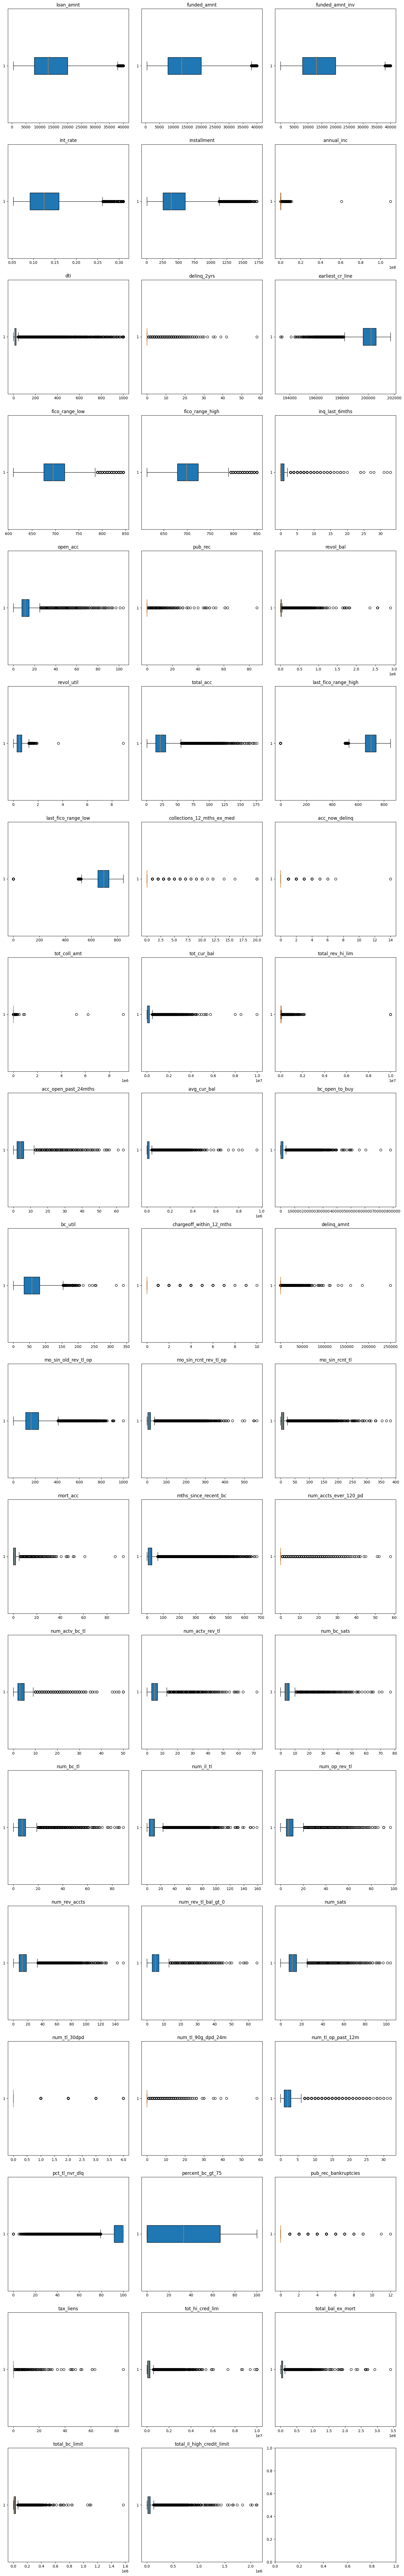

In [20]:
# 🔹 수치형 피처만 선택
numerical_columns = data.select_dtypes(include=[np.number]).columns

# 🔹 Boxplot 시각화 (이상치 확인)
fig, axes = plt.subplots(nrows=len(numerical_columns)//3 + 1, ncols=3, figsize=(15, 5 * (len(numerical_columns)//3 + 1)))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    axes[i].boxplot(data[col].dropna(), vert=False, patch_artist=True)
    axes[i].set_title(col)

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

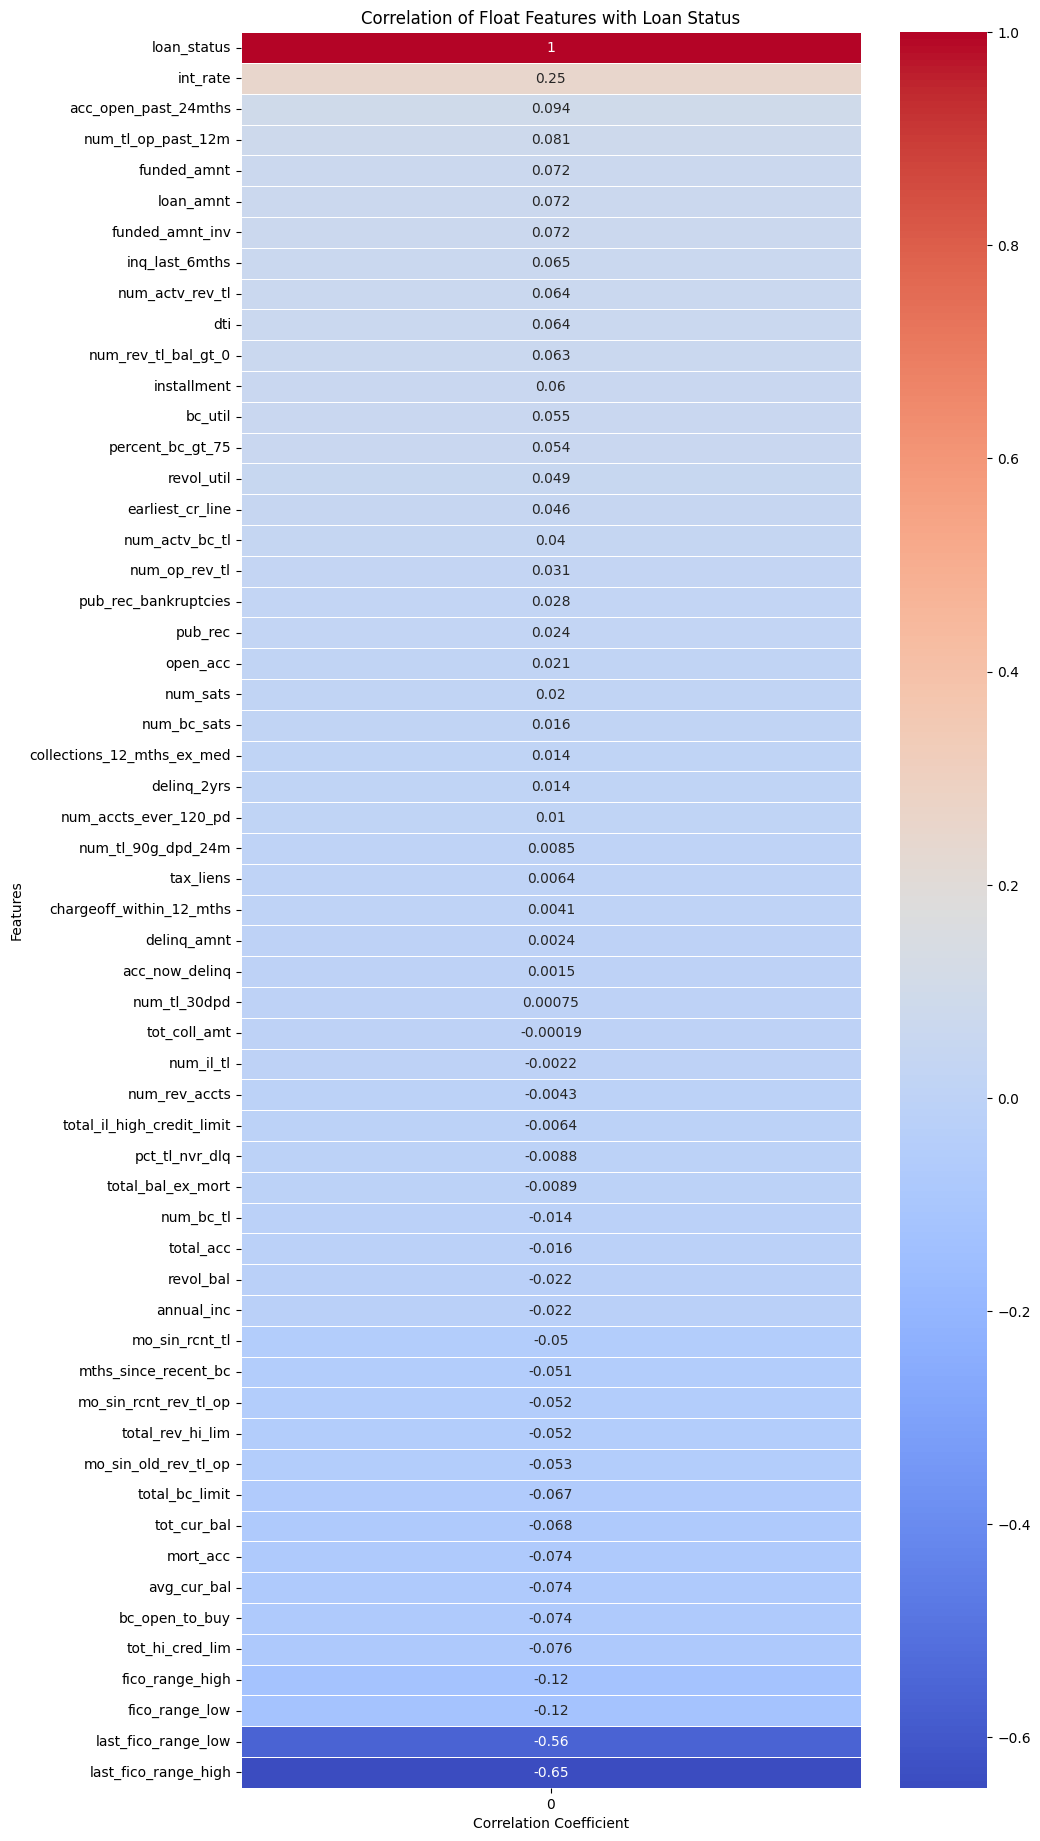

In [ ]:
## 이상치를 제거 전 Correlation 관계 보기.
##float형 중에서 loan_status에 가장 영향이 큰 거 찾는다
data.dtypes.value_counts()

dataset_features = data.select_dtypes(include=[np.number])
target = 'loan_status'

correlation_matrix = dataset_features.corrwith(data[target]).sort_values(ascending=False)

# 4. heatmap 시각화
plt.figure(figsize=(10, len(correlation_matrix) * 0.4))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation of Float Features with Loan Status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [22]:
##quantile 방식 1%제거 -> 논문 이상치 제거 방식.
def remove_outliers_percentile(df, columns, upper_q=0.99, lower_q=None):
    df_cleaned = df.copy()
    for col in columns:
        if lower_q:
            lower = df[col].quantile(lower_q)
            df_cleaned = df_cleaned[df_cleaned[col] >= lower]
        upper = df[col].quantile(upper_q)
        df_cleaned = df_cleaned[df_cleaned[col] <= upper]
    return df_cleaned

##IQR방식 기준 이상치 제거거
def remove_outliers_iqr(df, columns, factor=1.5):
    """
    boxplot 기준 이상치 제거 (Q1 - 1.5*IQR, Q3 + 1.5*IQR)
    """
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]
    return df_cleaned


In [23]:
numerical_columns = data.select_dtypes(include=[np.number]).columns

df_cleaned_percentile = remove_outliers_percentile(data, numerical_columns,upper_q=0.99)

df_cleaned_IQR = remove_outliers_iqr(data, numerical_columns)

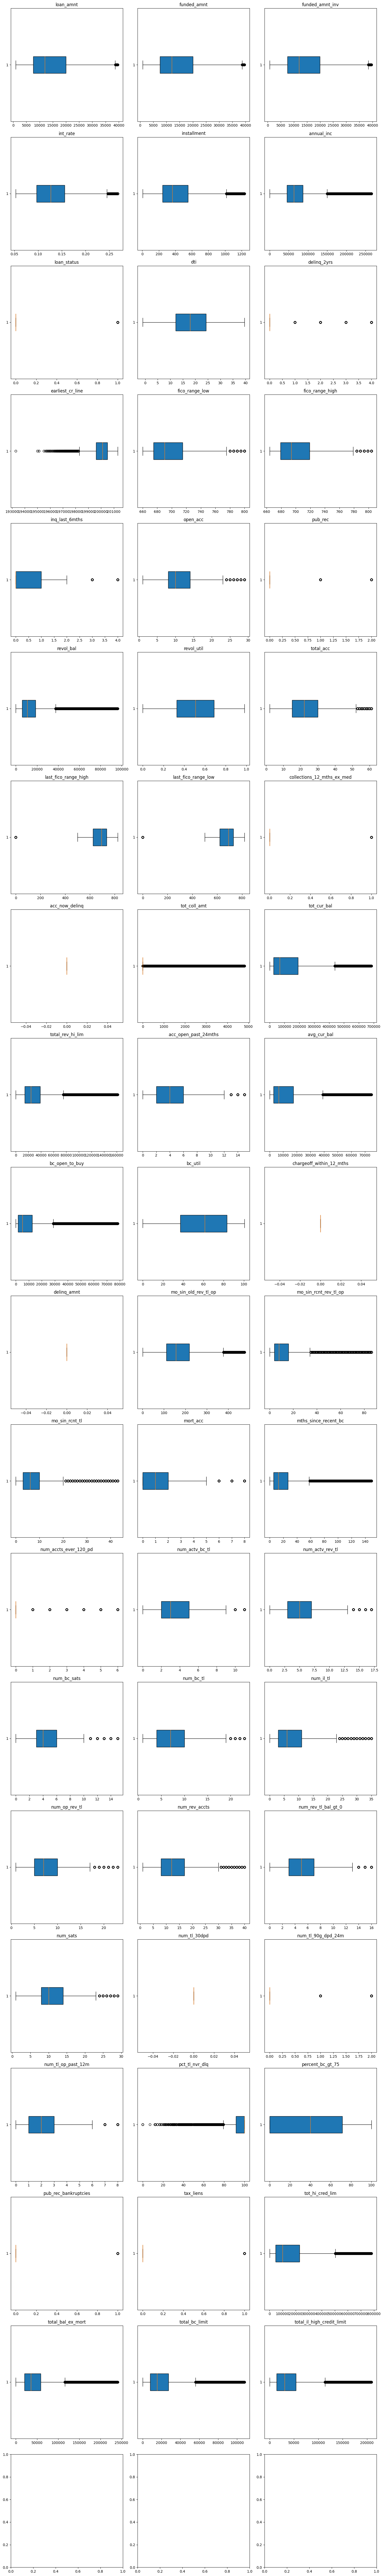

In [28]:
# 🔹 수치형 피처만 선택
numerical_columns = df_cleaned_percentile.select_dtypes(include=[np.number]).columns

# 🔹 Boxplot 시각화 (이상치 확인)
fig, axes = plt.subplots(nrows=len(numerical_columns)//3 + 1, ncols=3, figsize=(15, 5 * (len(numerical_columns)//3 + 1)))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    axes[i].boxplot(df_cleaned_percentile[col].dropna(), vert=False, patch_artist=True)
    axes[i].set_title(col)

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

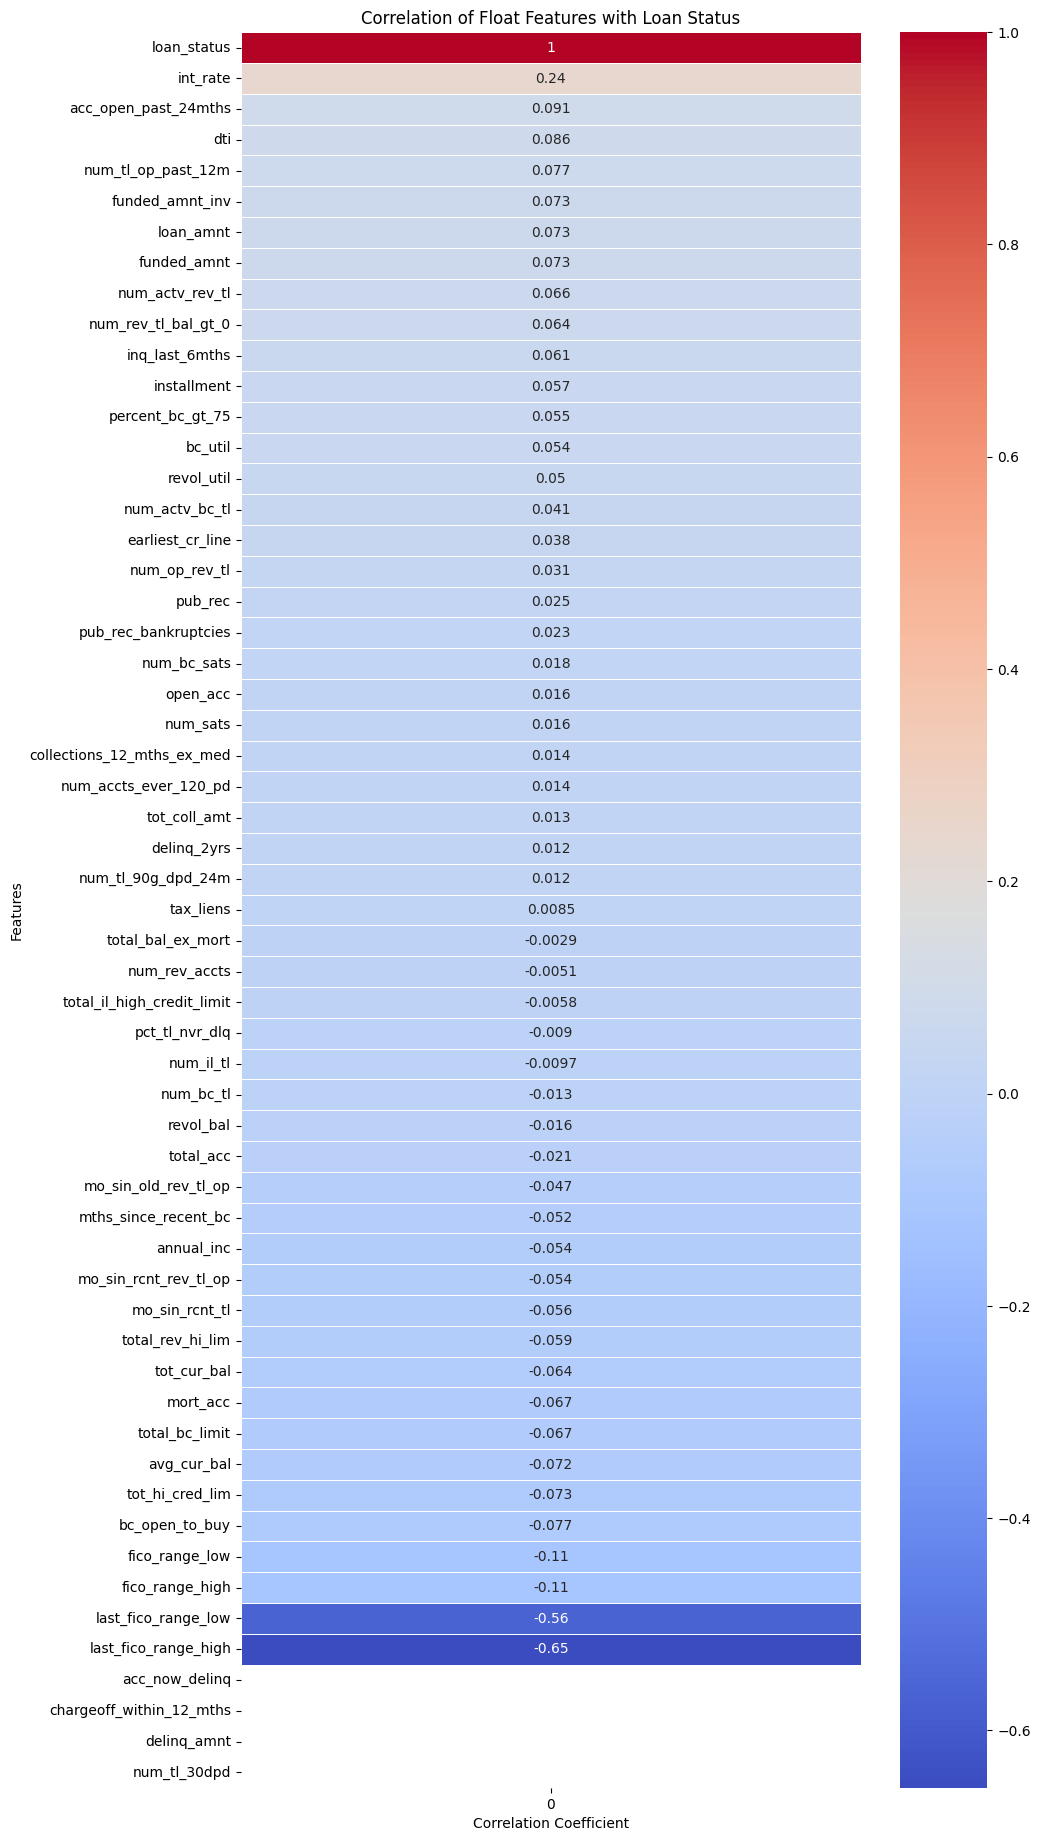

In [29]:
## 이상치를 제거 전 Correlation 관계 보기.
##float형 중에서 loan_status에 가장 영향이 큰 거 찾는다
df_cleaned_percentile.dtypes.value_counts()

dataset_features = df_cleaned_percentile.select_dtypes(include=[np.number])
target = 'loan_status'

correlation_matrix = dataset_features.corrwith(df_cleaned_percentile[target]).sort_values(ascending=False)

# 4. heatmap 시각화
plt.figure(figsize=(10, len(correlation_matrix) * 0.4))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation of Float Features with Loan Status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

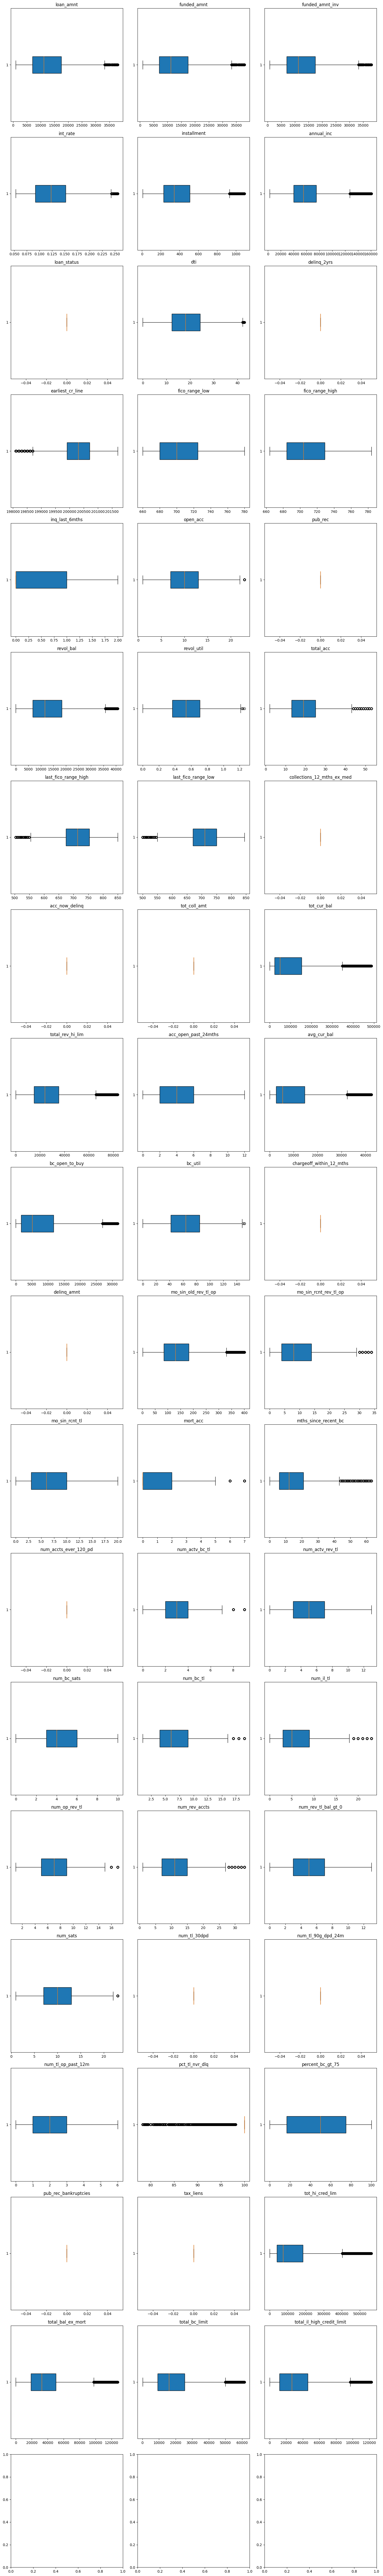

In [30]:
# 🔹 수치형 피처만 선택
numerical_columns = df_cleaned_IQR.select_dtypes(include=[np.number]).columns

# 🔹 Boxplot 시각화 (이상치 확인)
fig, axes = plt.subplots(nrows=len(numerical_columns)//3 + 1, ncols=3, figsize=(15, 5 * (len(numerical_columns)//3 + 1)))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    axes[i].boxplot(df_cleaned_IQR[col].dropna(), vert=False, patch_artist=True)
    axes[i].set_title(col)

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

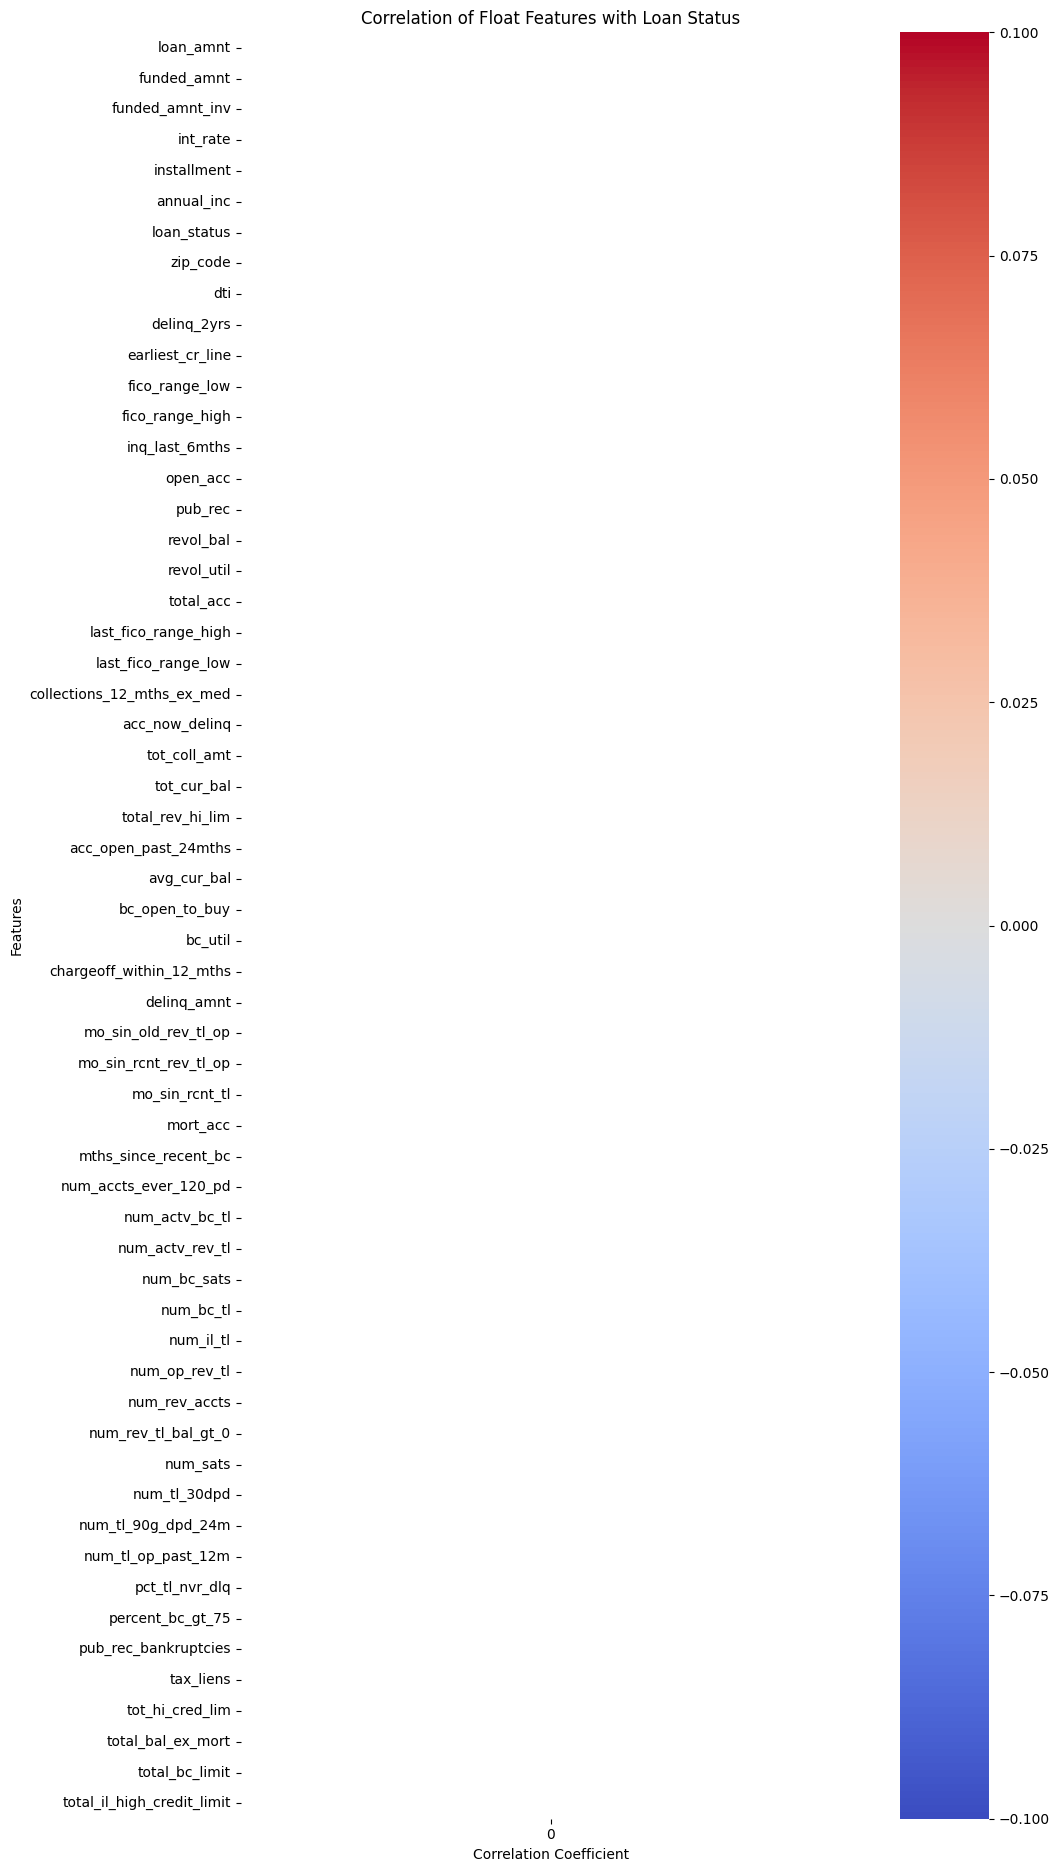

In [24]:
## 이상치를 제거 전 Correlation 관계 보기.
##float형 중에서 loan_status에 가장 영향이 큰 거 찾는다
df_cleaned_IQR.dtypes.value_counts()

dataset_features = df_cleaned_IQR.select_dtypes(include=[np.number])
target = 'loan_status'

correlation_matrix = dataset_features.corrwith(df_cleaned_IQR[target]).sort_values(ascending=False)

# 4. heatmap 시각화
plt.figure(figsize=(10, len(correlation_matrix) * 0.4))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation of Float Features with Loan Status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [25]:
print(f"original data samples : {len(data)}\nPercentile data samples : {len(df_cleaned_percentile)}\nIQR data samples : {len(df_cleaned_IQR)}")

original data samples : 1860764
Percentile data samples : 1343217
IQR data samples : 312798


In [26]:
object_features = df_cleaned_percentile.select_dtypes(include=['object','category'])

for col in object_features:
    print(f"{col} features values:\n    {df_cleaned_percentile[col].unique()}")

print(f"The number of remain object features : {len(object_features.columns)}")

term features values:
    [' 36 months' ' 60 months']
grade features values:
    ['B' 'A' 'C' 'E' 'D' 'F' 'G']
sub_grade features values:
    ['B2' 'A3' 'B4' 'A2' 'A5' 'C5' 'B3' 'C3' 'C1' 'E4' 'B5' 'C2' 'B1' 'D2'
 'E2' 'E1' 'A1' 'C4' 'D5' 'A4' 'D3' 'E3' 'F1' 'D4' 'D1' 'G3' 'F2' 'F4'
 'G4' 'E5' 'G5' 'F3' 'G2' 'F5' 'G1']
home_ownership features values:
    ['RENT' 'MORTGAGE' 'OWN' 'NONE' 'OTHER' 'ANY']
verification_status features values:
    ['Not Verified' 'Source Verified' 'Verified']
purpose features values:
    ['debt_consolidation' 'home_improvement' 'other' 'credit_card'
 'major_purchase' 'small_business' 'house' 'moving' 'medical' 'car'
 'vacation' 'renewable_energy' 'wedding' 'educational']
addr_state features values:
    ['NC' 'TX' 'CT' 'FL' 'CA' 'CO' 'NY' 'MI' 'MA' 'PA' 'NJ' 'SC' 'OH' 'AZ'
 'DE' 'KY' 'GA' 'WI' 'MO' 'IL' 'TN' 'WA' 'NM' 'MD' 'VA' 'MN' 'WY' 'NV'
 'IN' 'KS' 'AL' 'RI' 'NH' 'OR' 'WV' 'LA' 'VT' 'AR' 'OK' 'HI' 'MT' 'UT'
 'SD' 'DC' 'NE' 'AK' 'MS' 'ID' 'ME' 'ND' 'IA']
i

In [26]:
categorical_cols = [
    'term',
    'grade',
    'sub_grade',
    'home_ownership',
    'verification_status',
    'purpose',
    'addr_state',
    'initial_list_status',
    'application_type',
    'hardship_flag',
    'debt_settlement_flag'
]

# 원-핫 인코딩 수행 (NaN도 처리되도록 dummy_na=False로 설정)
data_encoded = pd.get_dummies(df_cleaned_percentile, columns=categorical_cols, dummy_na=False)

print(f"One-hot encoding 완료 변환 후 컬럼 수: {data_encoded.shape[1]}")

One-hot encoding 완료 변환 후 컬럼 수: 184


In [27]:
## one - hot encoding 되기 전 68개 feature 중, categorical data 12개를 제외하면 56개 nan값 대체
# 수치형(numeric) 변수만 선택
numeric_cols = data_encoded.select_dtypes(include=[np.number]).columns

print(len(numeric_cols))

# 각 컬럼별 평균값으로 결측치 채우기
data_encoded[numeric_cols] = data_encoded[numeric_cols].fillna(data_encoded[numeric_cols].mean())

print("✅ 모든 수치형 컬럼의 결측치를 평균값으로 대체 완료!")


58
✅ 모든 수치형 컬럼의 결측치를 평균값으로 대체 완료!


In [28]:
data_x = data_encoded.drop(columns='loan_status')
data_y = data_encoded['loan_status']

✅ Top 20 features selected by XGBoost:
['last_fico_range_high', 'earliest_cr_line', 'mo_sin_old_rev_tl_op', 'int_rate', 'annual_inc', 'dti', 'zip_code', 'installment', 'fico_range_low', 'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'revol_util', 'revol_bal', 'total_acc', 'bc_util', 'total_il_high_credit_limit', 'total_bal_ex_mort', 'mths_since_recent_bc', 'num_bc_tl']


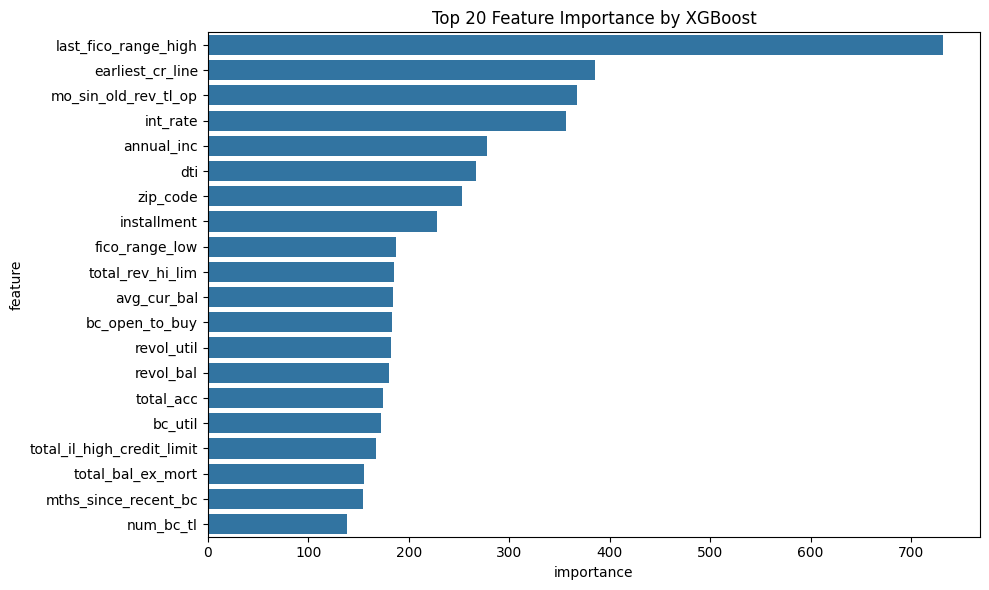

In [29]:
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# DMatrix 생성 (feature 이름 지정)
dtrain = xgb.DMatrix(data_x, label=data_y, feature_names=data_x.columns.tolist())

# XGBoost 파라미터
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'verbosity': 0
}

# 학습
xgb_model = xgb.train(params, dtrain, num_boost_round=150)

# Feature Importance
importance_dict = xgb_model.get_score(importance_type='weight')

# 정렬
sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
top_20 = [feat for feat, score in sorted_features[:20]]

print("✅ Top 20 features selected by XGBoost:")
print(top_20)

# DataFrame for visualization
importance_df = pd.DataFrame(sorted_features, columns=["feature", "importance"])

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=importance_df.head(20))
plt.title("Top 20 Feature Importance by XGBoost")
plt.tight_layout()
plt.show()

In [30]:
top_15 = [feat for feat,score in sorted_features[:15]]
print(top_15)

['last_fico_range_high', 'earliest_cr_line', 'mo_sin_old_rev_tl_op', 'int_rate', 'annual_inc', 'dti', 'zip_code', 'installment', 'fico_range_low', 'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'revol_util', 'revol_bal', 'total_acc']


In [31]:
# issue_d, term feature 살리기
select_data_time = ['issue_d', 'term', 'loan_status','grade']
select_return_feature = ['total_pymnt','total_pymnt_inv','loan_amnt']
select_features = top_15 + select_data_time + select_return_feature

data_original2 = data_original[select_features]

data_original2.head()

,last_fico_range_high,earliest_cr_line,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,zip_code,installment,fico_range_low,total_rev_hi_lim,...,revol_util,revol_bal,total_acc,issue_d,term,loan_status,grade,total_pymnt,total_pymnt_inv,loan_amnt
0,704.0,Jan-1985,NaN,10.65%,24000.0,27.65,860xx,162.87,735.0,NaN,...,83.7%,13648.0,9.0,Dec-2011,36 months,Fully Paid,B,5863.155187,5833.84,5000.0
1,499.0,Apr-1999,NaN,15.27%,30000.0,1.00,309xx,59.83,740.0,NaN,...,9.4%,1687.0,4.0,Dec-2011,60 months,Charged Off,C,1014.530000,1014.53,2500.0
2,739.0,Nov-2001,NaN,15.96%,12252.0,8.72,606xx,84.33,735.0,NaN,...,98.5%,2956.0,10.0,Dec-2011,36 months,Fully Paid,C,3005.666844,3005.67,2400.0
3,604.0,Feb-1996,NaN,13.49%,49200.0,20.00,917xx,339.31,690.0,NaN,...,21%,5598.0,37.0,Dec-2011,36 months,Fully Paid,C,12231.890000,12231.89,10000.0
4,684.0,Jan-1996,NaN,12.69%,80000.0,17.94,972xx,67.79,695.0,NaN,...,53.9%,27783.0,38.0,Dec-2011,60 months,Fully Paid,B,4066.908161,4066.91,3000.0


In [32]:
#83.7% -> 0.837
def converting_cat_to_num(x):
    if not isinstance(x, str):
        return x
    return float(x.strip().replace('%', '')) / 100

# Converting numerically data stored as categorical
data_original2['int_rate'] = data_original2['int_rate'].map(converting_cat_to_num)
data_original2['revol_util'] = data_original2['revol_util'].map(converting_cat_to_num)

print("Successfully converted!")
display(data_original2[['int_rate','revol_util']].head())

Successfully converted!


,int_rate,revol_util
0,0.1065,0.837
1,0.1527,0.094
2,0.1596,0.985
3,0.1349,0.210
4,0.1269,0.539


In [33]:
#zip code 뒤에 x 2개 빼고 float형 변환
def filter_zip_code(x):
    if not isinstance(x,str):
        return x
    return int(x[:3])


# Filtering the zip code
data_original2["zip_code"] = data_original2["zip_code"].map(filter_zip_code)

print("Successfully converted!")
display(data_original2[['zip_code']].head())

Successfully converted!


,zip_code
0,860.0
1,309.0
2,606.0
3,917.0
4,972.0


In [34]:
##issue_d - earliest_cr_line = 신용 계좌를 유지한 년도

# 1. issue_d가 NaN인 경우 제거
data_cleaned = data_original2.dropna(subset=['issue_d']).copy()

# 2. 문자열을 datetime으로 변환
data_cleaned['issue_d_dt'] = pd.to_datetime(data_cleaned['issue_d'], format='%b-%Y', errors='coerce')
data_cleaned['earliest_cr_line_dt'] = pd.to_datetime(data_cleaned['earliest_cr_line'], format='%b-%Y', errors='coerce')

# 3. 년도 차이 계산 (연도만 추출 후 차이 계산)
data_cleaned['credit_history_years'] = data_cleaned['issue_d_dt'].dt.year - data_cleaned['earliest_cr_line_dt'].dt.year

# 4. 타입 변환 (float → int), NaN 유지
data_cleaned['credit_history_years'] = data_cleaned['credit_history_years'].astype('Int64')  # pandas nullable int

# 결과 확인
print(data_cleaned[['issue_d', 'earliest_cr_line', 'credit_history_years']].head())

    issue_d earliest_cr_line  credit_history_years
0  Dec-2011         Jan-1985                    26
1  Dec-2011         Apr-1999                    12
2  Dec-2011         Nov-2001                    10
3  Dec-2011         Feb-1996                    15
4  Dec-2011         Jan-1996                    15


In [35]:
##데이터셋에서 loan_status가 fully_paid, Charged Off, Default만 살리기

data_cleaned = data_cleaned[data_cleaned['loan_status'].isin(["Fully Paid", "Charged Off", "Default"])]
print(data_cleaned['loan_status'].value_counts())

data_cleaned['loan_status'] = data_cleaned['loan_status'].replace("Charged Off", "Default")
print('\n',data_cleaned['loan_status'].value_counts())

loan_status
Fully Paid     1497783
Charged Off     362548
Default            433
Name: count, dtype: int64

 loan_status
Fully Paid    1497783
Default        362981
Name: count, dtype: int64


In [36]:
# For transforming the problem into a binary classification we will encode the target so that it contains only 1, 0, and nan.
mapping = {
    "Fully Paid" : 0,
    "Default" : 1
}

def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan

# Performing the encoding
data_cleaned['loan_status'] = data_cleaned['loan_status'].map(encoding_target)
    
# Droping all irrelevant data
# data.dropna(subset=['loan_status'],inplace=True)

In [37]:
drop_features = ['issue_d','earliest_cr_line','issue_d_dt','earliest_cr_line_dt']
data_cleaned = data_cleaned.drop(columns=drop_features)

In [38]:
data_cleaned.head(10)

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,zip_code,installment,fico_range_low,total_rev_hi_lim,avg_cur_bal,...,revol_util,revol_bal,total_acc,term,loan_status,grade,total_pymnt,total_pymnt_inv,loan_amnt,credit_history_years
0,704.0,NaN,0.1065,24000.0,27.65,860.0,162.87,735.0,NaN,NaN,...,0.837,13648.0,9.0,36 months,0,B,5863.155187,5833.84,5000.0,26
1,499.0,NaN,0.1527,30000.0,1.00,309.0,59.83,740.0,NaN,NaN,...,0.094,1687.0,4.0,60 months,1,C,1014.530000,1014.53,2500.0,12
2,739.0,NaN,0.1596,12252.0,8.72,606.0,84.33,735.0,NaN,NaN,...,0.985,2956.0,10.0,36 months,0,C,3005.666844,3005.67,2400.0,10
3,604.0,NaN,0.1349,49200.0,20.00,917.0,339.31,690.0,NaN,NaN,...,0.210,5598.0,37.0,36 months,0,C,12231.890000,12231.89,10000.0,15
4,684.0,NaN,0.1269,80000.0,17.94,972.0,67.79,695.0,NaN,NaN,...,0.539,27783.0,38.0,60 months,0,B,4066.908161,4066.91,3000.0,15
5,564.0,NaN,0.0790,36000.0,11.20,852.0,156.46,730.0,NaN,NaN,...,0.283,7963.0,12.0,36 months,0,A,5632.210000,5632.21,5000.0,7
6,654.0,NaN,0.1596,47004.0,23.51,280.0,170.08,690.0,NaN,NaN,...,0.856,17726.0,11.0,60 months,0,C,10137.840008,10137.84,7000.0,6
7,689.0,NaN,0.1864,48000.0,5.35,900.0,109.43,660.0,NaN,NaN,...,0.875,8221.0,4.0,36 months,0,E,3939.135294,3939.14,3000.0,4
8,499.0,NaN,0.2128,40000.0,5.55,958.0,152.39,675.0,NaN,NaN,...,0.326,5210.0,13.0,60 months,1,F,647.500000,647.50,5600.0,7
9,504.0,NaN,0.1269,15000.0,18.08,774.0,121.45,725.0,NaN,NaN,...,0.365,9279.0,3.0,60 months,1,B,1484.590000,1477.70,5375.0,7


In [39]:
##term feature 변환
data_cleaned['term_months'] = data_cleaned['term'].str.extract(r'(\d+)').astype(int)
data_cleaned.head()

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,zip_code,installment,fico_range_low,total_rev_hi_lim,avg_cur_bal,...,revol_bal,total_acc,term,loan_status,grade,total_pymnt,total_pymnt_inv,loan_amnt,credit_history_years,term_months
0,704.0,NaN,0.1065,24000.0,27.65,860.0,162.87,735.0,NaN,NaN,...,13648.0,9.0,36 months,0,B,5863.155187,5833.84,5000.0,26,36
1,499.0,NaN,0.1527,30000.0,1.00,309.0,59.83,740.0,NaN,NaN,...,1687.0,4.0,60 months,1,C,1014.530000,1014.53,2500.0,12,60
2,739.0,NaN,0.1596,12252.0,8.72,606.0,84.33,735.0,NaN,NaN,...,2956.0,10.0,36 months,0,C,3005.666844,3005.67,2400.0,10,36
3,604.0,NaN,0.1349,49200.0,20.00,917.0,339.31,690.0,NaN,NaN,...,5598.0,37.0,36 months,0,C,12231.890000,12231.89,10000.0,15,36
4,684.0,NaN,0.1269,80000.0,17.94,972.0,67.79,695.0,NaN,NaN,...,27783.0,38.0,60 months,0,B,4066.908161,4066.91,3000.0,15,60


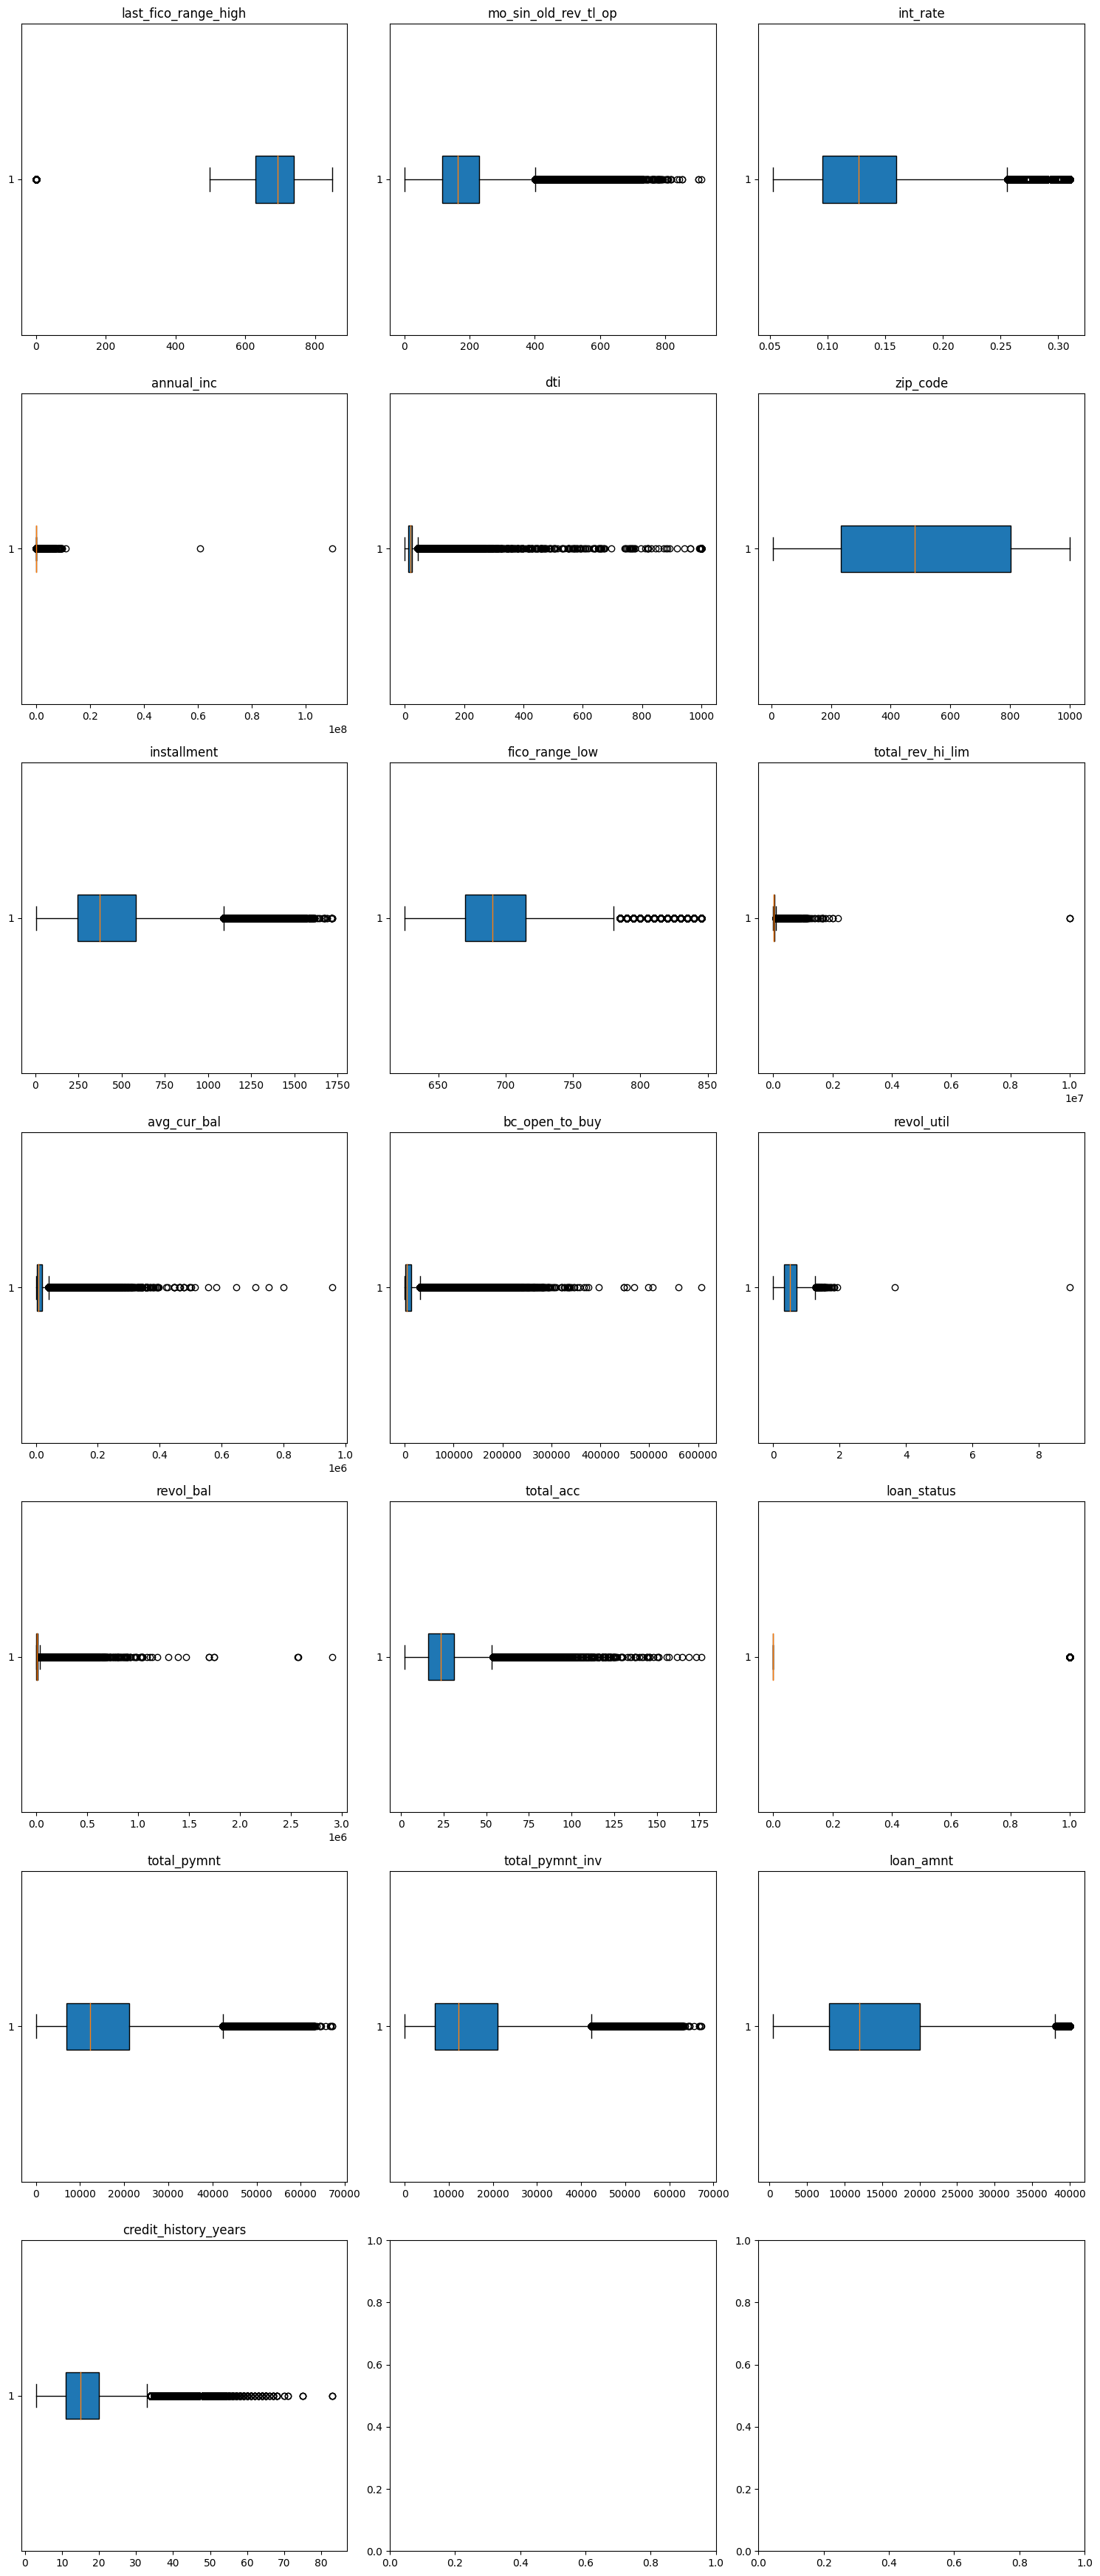

In [32]:
# 🔹 수치형 피처만 선택
numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns

# 🔹 Boxplot 시각화 (이상치 확인)
fig, axes = plt.subplots(nrows=len(numerical_columns)//3 + 1, ncols=3, figsize=(15, 5 * (len(numerical_columns)//3 + 1)))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    axes[i].boxplot(data_cleaned[col].dropna(), vert=False, patch_artist=True)
    axes[i].set_title(col)

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

In [40]:
##missing value값 처리
## one - hot encoding 되기 전 68개 feature 중, categorical data 12개를 제외하면 56개 nan값 대체
# 수치형(numeric) 변수만 선택
numeric_cols = data_cleaned.select_dtypes(include=[np.number]).columns

print(len(numeric_cols))

# 각 컬럼별 평균값으로 결측치 채우기
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].mean())

print("✅ 모든 수치형 컬럼의 결측치를 평균값으로 대체 완료!")


20
✅ 모든 수치형 컬럼의 결측치를 평균값으로 대체 완료!


In [41]:
data_cleaned = data_cleaned.drop(columns='term')

In [ ]:
"""data_cleaned_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
data_cleaned.to_csv(path_or_buf=data_cleaned_path+"Dataset_with_grade.csv", index=False)"""

In [34]:
data_x = data_cleaned.drop(columns='loan_status')
data_y = data_cleaned[['loan_status']]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_cleaned):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_cleaned):.1%})")

Train size: 1488611 samples (80.0%)
Test size: 372153 samples (20.0%)


In [36]:
#train_dataset = pd.concat([X_train,y_train], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)

#train_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
#train_dataset.to_csv(path_or_buf=train_path+"train_dataset.csv", index=False)

test_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
test_dataset.to_csv(path_or_buf=test_path+"return_feature_test.csv", index=False)

#train_dataset1 = train_dataset[train_dataset['loan_status'] == 1]
#train1_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
#train_dataset1.to_csv(path_or_buf=train1_path+"train_dataset_label_1.csv", index=False)

## 전체 데이터셋 return 값 histplot뽑기

In [43]:
data_original3 = data_original.copy()

data_original3 = data_original3[data_original3['loan_status'].isin(["Fully Paid", "Charged Off", "Default"])]
print(data_original3['loan_status'].value_counts())

data_original3['loan_status'] = data_original3['loan_status'].replace("Charged Off", "Default")
print('\n',data_original3['loan_status'].value_counts())

# For transforming the problem into a binary classification we will encode the target so that it contains only 1, 0, and nan.
mapping = {
    "Fully Paid" : 0,
    "Default" : 1
}

def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan

# Performing the encoding
data_original3['loan_status'] = data_original3['loan_status'].map(encoding_target)
    
# Droping all irrelevant data
# data.dropna(subset=['loan_status'],inplace=True)

loan_status
Fully Paid     1497783
Charged Off     362548
Default            433
Name: count, dtype: int64

 loan_status
Fully Paid    1497783
Default        362981
Name: count, dtype: int64


In [44]:
data_original3['term_months'] = data_original3['term'].str.extract(r'(\d+)').astype(int)
term_col = 'term_months'
print(f"before dropna : {len(data_original3[term_col])}")

data_original3[term_col] = data_original3[term_col].dropna()

print(f"After dropna : {len(data_original3[term_col])}")


before dropna : 1860764
After dropna : 1860764


In [45]:
return_cols = ['total_pymnt_inv', 'loan_amnt']

for col in return_cols:
    print(f"before {col} dropna : {len(data_original3[col])}")
    data_original3[col] = data_original3[col].fillna(data_original3[col].mean())
    print(f"After {col} dropna : {len(data_original3[col])}")

before total_pymnt_inv dropna : 1860764
After total_pymnt_inv dropna : 1860764
before loan_amnt dropna : 1860764
After loan_amnt dropna : 1860764


In [49]:
data_original3['annualized_return'] = (data_original3['total_pymnt_inv'] / data_original3['loan_amnt']) ** (12 / data_original3['term_months']) - 1
data_original3['return'] = (data_original3['total_pymnt_inv']-data_original3['loan_amnt'])/data_original3['loan_amnt']

data_original3['annualized_return_percent'] = data_original3['annualized_return'] * 100
data_original3['return_percent'] = data_original3['return']*100

data_original3[['loan_status','annualized_return_percent', 'return_percent']].head()

,loan_status,annualized_return_percent,return_percent
0,0,5.275708,16.676800
1,1,-16.504133,-59.418800
2,0,7.789556,25.236250
3,0,6.945994,22.318900
4,0,6.274400,35.563667


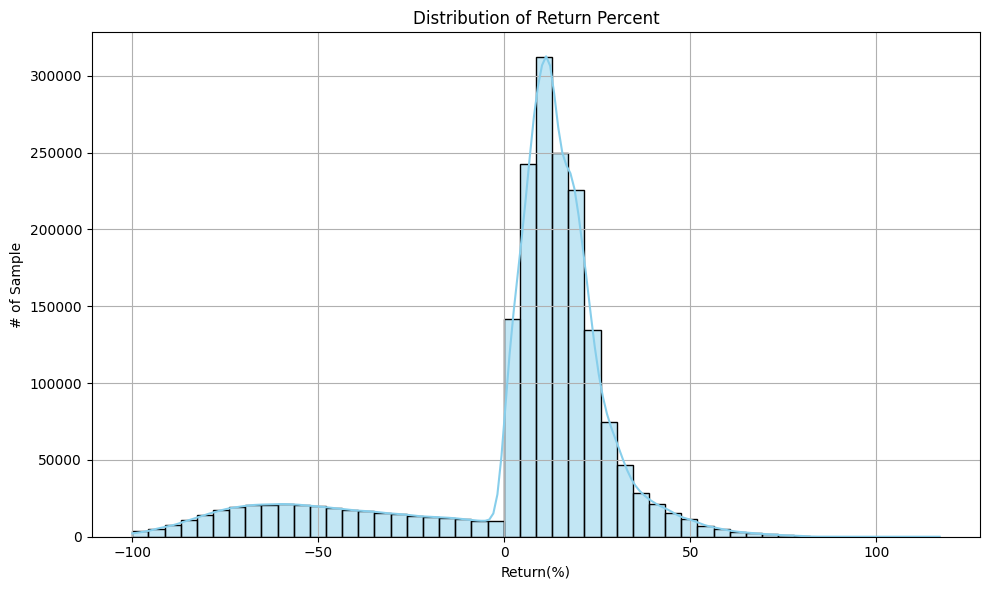

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=data_original3, x='return_percent', bins=50, kde=True, color='skyblue')
plt.title('Distribution of Return Percent')
plt.xlabel('Return(%)')
plt.ylabel('# of Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

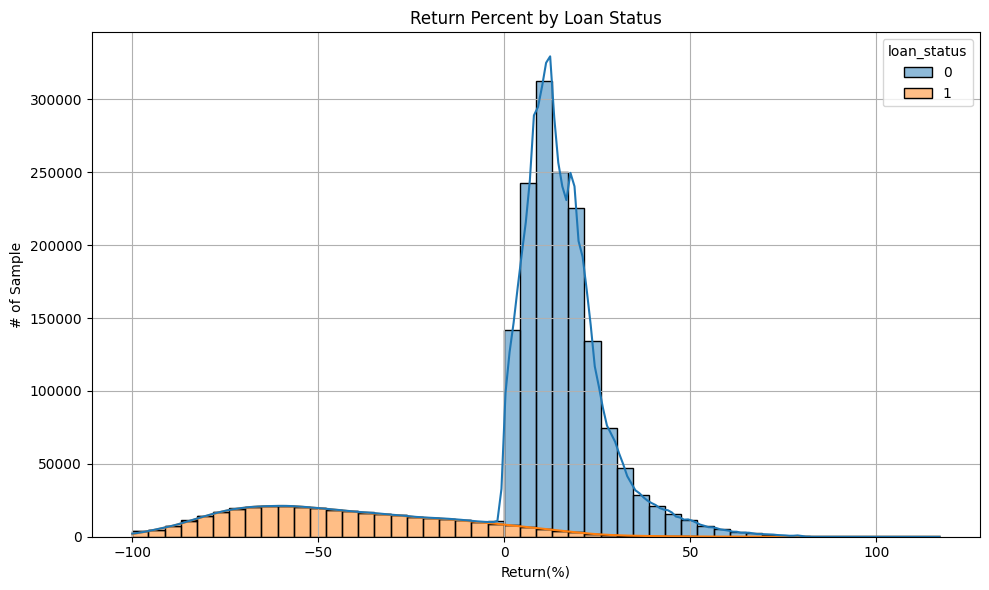

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_original3, x='return_percent', hue='loan_status', bins=50, kde=True, multiple='stack')
plt.title('Return Percent by Loan Status')
plt.xlabel('Return(%)')
plt.ylabel('# of Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

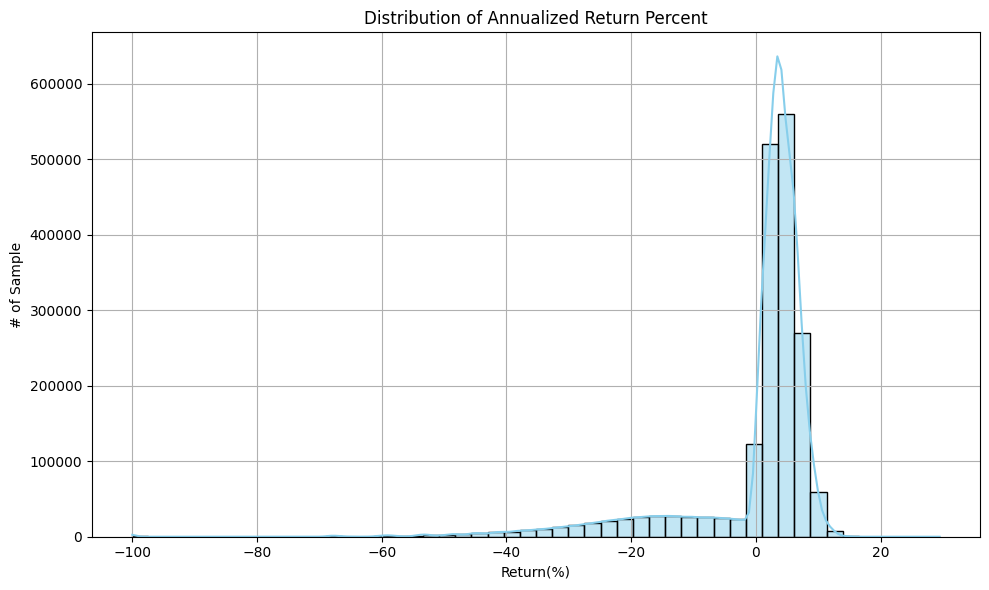

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=data_original3, x='annualized_return_percent', bins=50, kde=True, color='skyblue')
plt.title('Distribution of Annualized Return Percent')
plt.xlabel('Return(%)')
plt.ylabel('# of Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

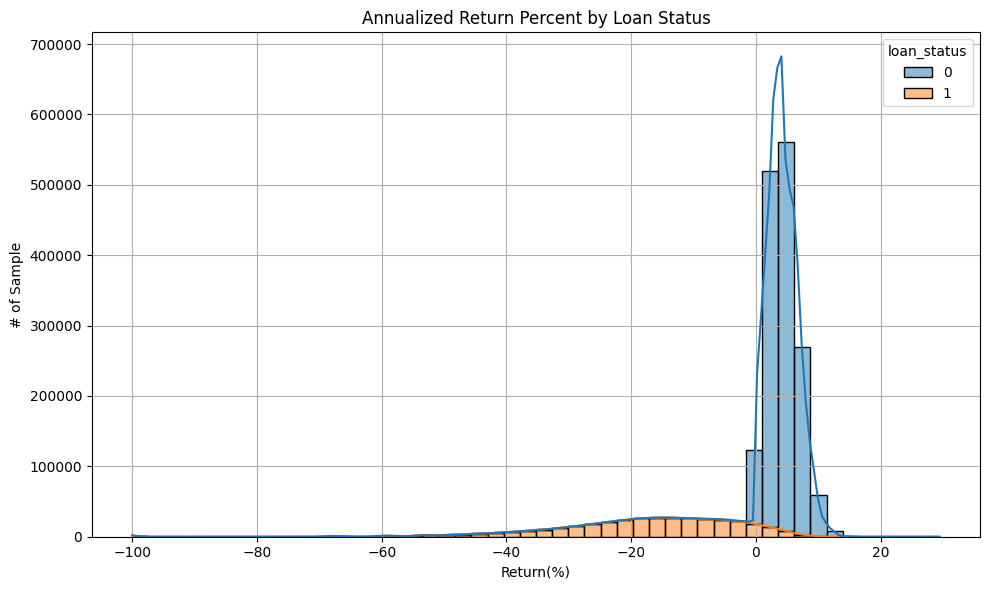

In [57]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_original3, x='annualized_return_percent', hue='loan_status', bins=50, kde=True, multiple='stack')
plt.title('Annualized Return Percent by Loan Status')
plt.xlabel('Return(%)')
plt.ylabel('# of Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
print("The number of NaN of each features")
print(f"Grade : {data_original3['grade'].isna().sum()}")
print(f"int_rate : {data_original3['int_rate'].isna().sum()}")

The number of NaN of each features
Grade : 0
int_rate : 0


In [72]:
#83.7% -> 0.837
def converting_cat_to_num(x):
    if not isinstance(x, str):
        return x
    return float(x.strip().replace('%', ''))

# Converting numerically data stored as categorical
data_original3['int_rate'] = data_original3['int_rate'].map(converting_cat_to_num)

print("Successfully converted!")
display(data_original3[['int_rate']].head())

Successfully converted!


,int_rate
0,10.65
1,15.27
2,15.96
3,13.49
4,12.69


In [77]:
# grade별로 그룹화하여 요약 통계 계산
grade_summary = data_original3.groupby("grade").agg(
    Loan_Amount=("loan_amnt", "sum"),  # 필요 시 loan_amnt도 포함 가능
    Interest_Rate=("int_rate", "mean"),
    Historical_Return=("annualized_return_percent", "mean"),
    Std_Deviation=("annualized_return_percent", "std")
).reset_index()

# 보기 좋게 소수점 2자리로 반올림
grade_summary = grade_summary.round({
    "Loan_Amount": 2,
    "Interest_Rate": 2,
    "Historical_Return": 2,
    "Std_Deviation": 2
})

# 전체 평균행 추가 (All row)
all_row = pd.DataFrame({
    "grade": ["All"],
    "Loan_Amount": [data_original3["loan_amnt"].sum()],
    "Interest_Rate": [data_original3["int_rate"].mean()],
    "Historical_Return": [data_original3["annualized_return_percent"].mean()],
    "Std_Deviation": [data_original3["annualized_return_percent"].std()]
}).round(2)

In [78]:
# All 행 추가
grade_summary = pd.concat([grade_summary, all_row], ignore_index=True)

# grade 컬럼 순서 정렬 (A~G, All)
grade_order = sorted(data_original3["grade"].unique().tolist()) + ["All"]
grade_summary["grade"] = pd.Categorical(grade_summary["grade"], categories=grade_order, ordered=True)
grade_summary = grade_summary.sort_values("grade").reset_index(drop=True)

# 결과 출력
print(grade_summary)

  grade   Loan_Amount  Interest_Rate  Historical_Return  Std_Deviation
0     A  4.876723e+09           7.13               0.98           7.71
1     B  7.404450e+09          10.69               0.84           9.76
2     C  7.642996e+09          14.12              -0.15          11.74
3     D  4.253599e+09          18.12              -1.24          13.73
4     E  2.040035e+09          21.54              -1.59          13.78
5     F  7.085681e+08          25.22              -2.31          13.96
6     G  2.196558e+08          27.98              -3.91          15.00
7   All  2.714603e+10          13.17               0.04          11.14


In [79]:
import pandas as pd

# 복사본 생성
df = grade_summary.copy()

# F, G 행만 필터링해서 합산
fg_combined = df[df['grade'].isin(['F', 'G'])].copy()

# 합산 후 F+G로 새 행 만들기
fg_row = pd.DataFrame({
    'grade': ['F+G'],
    'Loan_Amount': [fg_combined['Loan_Amount'].sum()],
    'Interest_Rate': [(
        fg_combined['Interest_Rate'] * fg_combined['Loan_Amount']
    ).sum() / fg_combined['Loan_Amount'].sum()],
    'Historical_Return': [(
        fg_combined['Historical_Return'] * fg_combined['Loan_Amount']
    ).sum() / fg_combined['Loan_Amount'].sum()],
    'Std_Deviation': [(
        fg_combined['Std_Deviation'] * fg_combined['Loan_Amount']
    ).sum() / fg_combined['Loan_Amount'].sum()]  # 근사치 평균 (정확한 합산 std는 별도 방식 필요)
})

# 기존 F, G 제거하고 F+G 추가
df = df[~df['grade'].isin(['F', 'G'])]
df = pd.concat([df, fg_row], ignore_index=True)

# grade 순서 재정렬
grade_order = ['A', 'B', 'C', 'D', 'E', 'F+G', 'All']
df['grade'] = pd.Categorical(df['grade'], categories=grade_order, ordered=True)
df = df.sort_values('grade').reset_index(drop=True)

print(df)


  grade   Loan_Amount  Interest_Rate  Historical_Return  Std_Deviation
0     A  4.876723e+09       7.130000           0.980000       7.710000
1     B  7.404450e+09      10.690000           0.840000       9.760000
2     C  7.642996e+09      14.120000          -0.150000      11.740000
3     D  4.253599e+09      18.120000          -1.240000      13.730000
4     E  2.040035e+09      21.540000          -1.590000      13.780000
5   F+G  9.282239e+08      25.873129          -2.688625      14.206107
6   All  2.714603e+10      13.170000           0.040000      11.140000


### Convert Categorical data to dummy data 

In [ ]:
object_features = data.select_dtypes(include=['object','category'])

for col in object_features:
    print(f"{col} features values:\n    {data[col].unique()}")

print(f"The number of remain object features : {len(object_features.columns)}")

term features values:
    [' 36 months' ' 60 months' nan]
grade features values:
    ['B' 'C' 'A' 'E' 'F' 'D' 'G' nan]
sub_grade features values:
    ['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5' nan]
home_ownership features values:
    ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' nan 'ANY']
verification_status features values:
    ['Verified' 'Source Verified' 'Not Verified' nan]
loan_status features values:
    ['Fully Paid' 'Charged Off' nan
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Current'
 'Late (31-120 days)' 'In Grace Period' 'Late (16-30 days)' 'Default'
 'Issued']
purpose features values:
    ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational' nan]
zip_

In [23]:
## Fully - Paid 바꾸기
#loan_data 특정 class만 살리고 Charged off -> Defalut class로 바꾸기기
data = data[data['loan_status'].isin(["Fully Paid", "Charged Off", "Default"])]
print(data['loan_status'].value_counts())

data['loan_status'] = data['loan_status'].replace("Charged Off", "Default")
print('\n',data['loan_status'].value_counts())

loan_status
Fully Paid     1497783
Charged Off     362548
Default            433
Name: count, dtype: int64

 loan_status
Fully Paid    1497783
Default        362981
Name: count, dtype: int64


In [24]:
# For transforming the problem into a binary classification we will encode the target so that it contains only 1, 0, and nan.
mapping = {
    "Fully Paid" : 0,
    "Default" : 1
}

def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan

# Performing the encoding
data['loan_status'] = data['loan_status'].map(encoding_target)
    
# Droping all irrelevant data
# data.dropna(subset=['loan_status'],inplace=True)

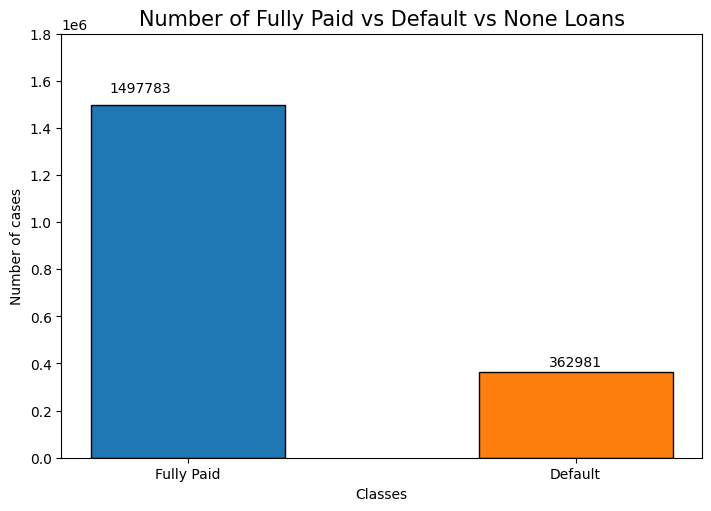

In [25]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Number of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
#ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [26]:
object_features = data.select_dtypes(include=['object','category'])

for col in object_features:
    print(f"{col} features values:\n    {data[col].unique()}")

print(f"The number of remain object features : {len(object_features.columns)}")

term features values:
    [' 36 months' ' 60 months']
grade features values:
    ['B' 'C' 'A' 'E' 'F' 'D' 'G']
sub_grade features values:
    ['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']
home_ownership features values:
    ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
verification_status features values:
    ['Verified' 'Source Verified' 'Not Verified']
purpose features values:
    ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
zip_code features values:
    ['860' '309' '606' '917' '972' '852' '280' '900' '958' '774' '853' '913'
 '245' '951' '641' '921' '067' '890' '770' '335' '799' '605' '103' '150'
 '326' '564' '141' '080' '330' '974' '934' '405' '946' '445' '850' '604'
 '292' '088' '180' '029' '700' '010' '441' '

### Categorical 변수 one - hot encoding

In [27]:
categorical_cols = [
    'term',
    'grade',
    'sub_grade',
    'home_ownership',
    'verification_status',
    'purpose',
    'zip_code',
    'addr_state',
    'initial_list_status',
    'application_type',
    'hardship_flag',
    'debt_settlement_flag'
]

# 원-핫 인코딩 수행 (NaN도 처리되도록 dummy_na=False로 설정)
data_encoded = pd.get_dummies(data, columns=categorical_cols, dummy_na=False)

print(f"One-hot encoding 완료 변환 후 컬럼 수: {data_encoded.shape[1]}")

One-hot encoding 완료 변환 후 컬럼 수: 1132


### Missing Value 처리 -> mean값 넣어주기

In [28]:
## one - hot encoding 되기 전 68개 feature 중, categorical data 12개를 제외하면 56개 nan값 대체
# 수치형(numeric) 변수만 선택
numeric_cols = data_encoded.select_dtypes(include=[np.number]).columns

print(len(numeric_cols))

# 각 컬럼별 평균값으로 결측치 채우기
data_encoded[numeric_cols] = data_encoded[numeric_cols].fillna(data_encoded[numeric_cols].mean())

print("✅ 모든 수치형 컬럼의 결측치를 평균값으로 대체 완료!")


57
✅ 모든 수치형 컬럼의 결측치를 평균값으로 대체 완료!


### Scaling 적용

In [ ]:
"""X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)

# 비율 출력
print("🔎 y_train label 비율:")
print(y_train.value_counts(normalize=True))

print("\n🔎 y_test label 비율:")
print(y_test.value_counts(normalize=True))

## 데이터 수 확인
print(f"Pre - train :\nThe number of train dataset : {len(X_train)}\nThe number of test dataset : {len(X_test)}")
"""

'X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)\n\n# 비율 출력\nprint("🔎 y_train label 비율:")\nprint(y_train.value_counts(normalize=True))\n\nprint("\n🔎 y_test label 비율:")\nprint(y_test.value_counts(normalize=True))'

In [29]:
data_x = data_encoded.drop(columns='loan_status')
data_y = data_encoded['loan_status']

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_x_scaled = scaler.fit_transform(data_x)

MemoryError: Unable to allocate 15.7 GiB for an array with shape (1131, 1860764) and data type float64

### Xgboost feature importance

In [29]:
data_y.value_counts()

loan_status
0    1497783
1     362981
Name: count, dtype: int64

✅ Top 20 features selected by XGBoost:
['last_fico_range_high', 'int_rate', 'mo_sin_old_rev_tl_op', 'earliest_cr_line', 'dti', 'annual_inc', 'zip_code', 'installment', 'fico_range_low', 'revol_util', 'total_acc', 'total_bc_limit', 'revol_bal', 'total_rev_hi_lim', 'bc_open_to_buy', 'bc_util', 'avg_cur_bal', 'total_bal_ex_mort', 'mths_since_recent_bc', 'pct_tl_nvr_dlq']


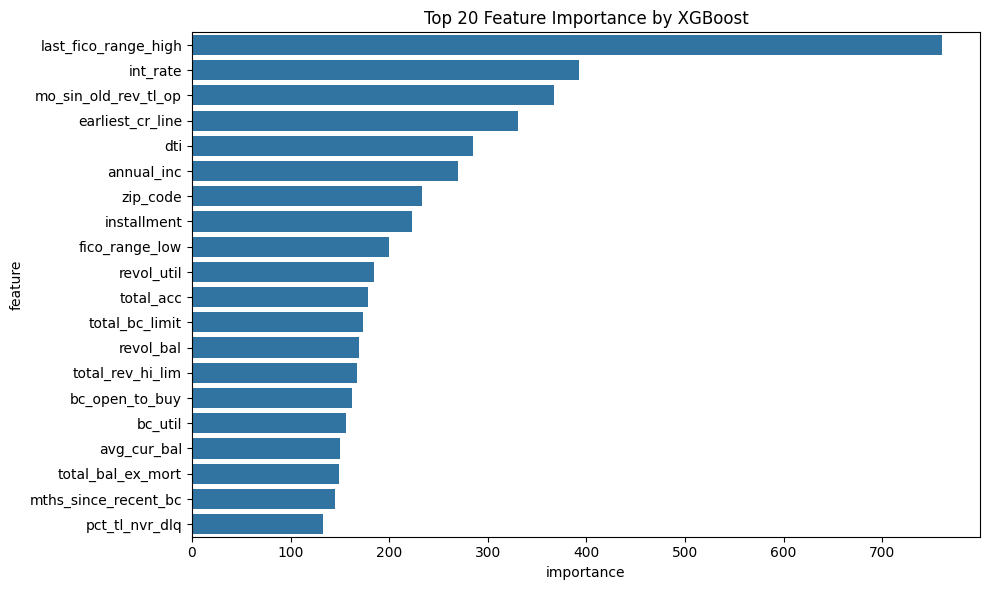

In [30]:
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# DMatrix 생성 (feature 이름 지정)
dtrain = xgb.DMatrix(data_x, label=data_y, feature_names=data_x.columns.tolist())

# XGBoost 파라미터
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'verbosity': 0
}

# 학습
xgb_model = xgb.train(params, dtrain, num_boost_round=150)

# Feature Importance
importance_dict = xgb_model.get_score(importance_type='weight')

# 정렬
sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
top_20 = [feat for feat, score in sorted_features[:20]]

print("✅ Top 20 features selected by XGBoost:")
print(top_20)

# DataFrame for visualization
importance_df = pd.DataFrame(sorted_features, columns=["feature", "importance"])

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=importance_df.head(20))
plt.title("Top 20 Feature Importance by XGBoost")
plt.tight_layout()
plt.show()

In [31]:
top_15 = [feat for feat,score in sorted_features[:15]]
print(top_15)

['last_fico_range_high', 'int_rate', 'mo_sin_old_rev_tl_op', 'earliest_cr_line', 'dti', 'annual_inc', 'zip_code', 'installment', 'fico_range_low', 'revol_util', 'total_acc', 'total_bc_limit', 'revol_bal', 'total_rev_hi_lim', 'bc_open_to_buy']


In [47]:
# issue_d, term feature 살리기
select_data_time = ['issue_d', 'term', 'loan_status']
select_features = top_15 + select_data_time

data_original2 = data_original[select_features]

data_original2.head()

,last_fico_range_high,int_rate,mo_sin_old_rev_tl_op,earliest_cr_line,dti,annual_inc,zip_code,installment,fico_range_low,revol_util,total_acc,total_bc_limit,revol_bal,total_rev_hi_lim,bc_open_to_buy,issue_d,term,loan_status
0,704.0,10.65%,NaN,Jan-1985,27.65,24000.0,860xx,162.87,735.0,83.7%,9.0,NaN,13648.0,NaN,NaN,Dec-2011,36 months,Fully Paid
1,499.0,15.27%,NaN,Apr-1999,1.00,30000.0,309xx,59.83,740.0,9.4%,4.0,NaN,1687.0,NaN,NaN,Dec-2011,60 months,Charged Off
2,739.0,15.96%,NaN,Nov-2001,8.72,12252.0,606xx,84.33,735.0,98.5%,10.0,NaN,2956.0,NaN,NaN,Dec-2011,36 months,Fully Paid
3,604.0,13.49%,NaN,Feb-1996,20.00,49200.0,917xx,339.31,690.0,21%,37.0,NaN,5598.0,NaN,NaN,Dec-2011,36 months,Fully Paid
4,684.0,12.69%,NaN,Jan-1996,17.94,80000.0,972xx,67.79,695.0,53.9%,38.0,NaN,27783.0,NaN,NaN,Dec-2011,60 months,Fully Paid


## Train - Test split하여 csv파일 만들기
    - Converting categorical data
        - int_rate, revol_util
        - zip_code
        - loan_status
        - earliest_cr_line : 처음 신용계좌를 개설한 날짜 -> issue_d (대출 승인 날짜) - earliest_cr_line

In [48]:
#83.7% -> 0.837
def converting_cat_to_num(x):
    if not isinstance(x, str):
        return x
    return float(x.strip().replace('%', '')) / 100

# Converting numerically data stored as categorical
data_original2['int_rate'] = data_original2['int_rate'].map(converting_cat_to_num)
data_original2['revol_util'] = data_original2['revol_util'].map(converting_cat_to_num)

print("Successfully converted!")
display(data_original2[['int_rate','revol_util']].head())

Successfully converted!


,int_rate,revol_util
0,0.1065,0.837
1,0.1527,0.094
2,0.1596,0.985
3,0.1349,0.210
4,0.1269,0.539


In [ ]:
#zip code 뒤에 x 2개 빼고 float형 변환
def filter_zip_code(x):
    if not isinstance(x,str):
        return x
    return int(x[0:-2])


# Filtering the zip code
data_original2["zip_code"] = data_original2["zip_code"].map(filter_zip_code)

print("Successfully converted!")
display(data_original2[['zip_code']].head())

Successfully converted!


,zip_code
0,0.860
1,0.309
2,0.606
3,0.917
4,0.972


In [50]:
##issue_d - earliest_cr_line = 신용 계좌를 유지한 년도

# 1. issue_d가 NaN인 경우 제거
data_cleaned = data_original2.dropna(subset=['issue_d']).copy()

# 2. 문자열을 datetime으로 변환
data_cleaned['issue_d_dt'] = pd.to_datetime(data_cleaned['issue_d'], format='%b-%Y', errors='coerce')
data_cleaned['earliest_cr_line_dt'] = pd.to_datetime(data_cleaned['earliest_cr_line'], format='%b-%Y', errors='coerce')

# 3. 년도 차이 계산 (연도만 추출 후 차이 계산)
data_cleaned['credit_history_years'] = data_cleaned['issue_d_dt'].dt.year - data_cleaned['earliest_cr_line_dt'].dt.year

# 4. 타입 변환 (float → int), NaN 유지
data_cleaned['credit_history_years'] = data_cleaned['credit_history_years'].astype('Int64')  # pandas nullable int

# 결과 확인
print(data_cleaned[['issue_d', 'earliest_cr_line', 'credit_history_years']].head())


    issue_d earliest_cr_line  credit_history_years
0  Dec-2011         Jan-1985                    26
1  Dec-2011         Apr-1999                    12
2  Dec-2011         Nov-2001                    10
3  Dec-2011         Feb-1996                    15
4  Dec-2011         Jan-1996                    15


In [51]:
data_cleaned.head()

,last_fico_range_high,int_rate,mo_sin_old_rev_tl_op,earliest_cr_line,dti,annual_inc,zip_code,installment,fico_range_low,revol_util,...,total_bc_limit,revol_bal,total_rev_hi_lim,bc_open_to_buy,issue_d,term,loan_status,issue_d_dt,earliest_cr_line_dt,credit_history_years
0,704.0,0.1065,NaN,Jan-1985,27.65,24000.0,0.860,162.87,735.0,0.837,...,NaN,13648.0,NaN,NaN,Dec-2011,36 months,Fully Paid,2011-12-01,1985-01-01,26
1,499.0,0.1527,NaN,Apr-1999,1.00,30000.0,0.309,59.83,740.0,0.094,...,NaN,1687.0,NaN,NaN,Dec-2011,60 months,Charged Off,2011-12-01,1999-04-01,12
2,739.0,0.1596,NaN,Nov-2001,8.72,12252.0,0.606,84.33,735.0,0.985,...,NaN,2956.0,NaN,NaN,Dec-2011,36 months,Fully Paid,2011-12-01,2001-11-01,10
3,604.0,0.1349,NaN,Feb-1996,20.00,49200.0,0.917,339.31,690.0,0.210,...,NaN,5598.0,NaN,NaN,Dec-2011,36 months,Fully Paid,2011-12-01,1996-02-01,15
4,684.0,0.1269,NaN,Jan-1996,17.94,80000.0,0.972,67.79,695.0,0.539,...,NaN,27783.0,NaN,NaN,Dec-2011,60 months,Fully Paid,2011-12-01,1996-01-01,15


In [60]:
data_cleaned['issue_d'].value_counts()

issue_d
Mar-2016    61992
Jul-2019    50540
Oct-2015    48631
Aug-2019    47554
May-2018    46311
            ...  
Aug-2007       74
Jul-2007       63
Sep-2008       57
Sep-2007       53
Jun-2007       24
Name: count, Length: 160, dtype: int64

In [61]:
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime

# 1. 2019년도 issue_d만 선택
data_2019 = data_cleaned[data_cleaned['issue_d'].str.contains('2019', na=False)].copy()

# 2. 문자열 issue_d → datetime 변환
data_2019['issue_d_parsed'] = pd.to_datetime(data_2019['issue_d'], format='%b-%Y')

# 3. term을 숫자형으로 변환 (ex. ' 36 months' → 36)
data_2019['term_months'] = data_2019['term'].str.extract('(\d+)').astype(int)

# 4. 만기일 계산
data_2019['maturity_date'] = data_2019['issue_d_parsed'] + data_2019['term_months'].apply(lambda x: relativedelta(months=x))

# 5. 만기일이 2020년 12월 이전이면 유지
cutoff = datetime(2021, 1, 1)
data_due_by_2020 = data_2019[data_2019['maturity_date'] < cutoff]

# 6. loan_status 분포 확인
loan_status_counts = data_due_by_2020['loan_status'].value_counts()

print("📊 Loan status distribution for loans issued in 2019 and maturing before 2021:")
print(loan_status_counts)


📊 Loan status distribution for loans issued in 2019 and maturing before 2021:
Series([], Name: count, dtype: int64)


In [62]:
## Current loan_status가 있기 때문에 term이랑 issue_d를 무시해도 가능.
data_2019.head()

,last_fico_range_high,int_rate,mo_sin_old_rev_tl_op,earliest_cr_line,dti,annual_inc,zip_code,installment,fico_range_low,revol_util,...,bc_open_to_buy,issue_d,term,loan_status,issue_d_dt,earliest_cr_line_dt,credit_history_years,issue_d_parsed,term_months,maturity_date
967308,659.0,0.1390,230.0,Jan-2000,23.54,86000.0,0.360,557.20,665.0,0.731,...,3112.0,Mar-2019,60 months,Current,2019-03-01,2000-01-01,19,2019-03-01,60,2024-03-01 00:00:00
967309,789.0,0.1474,75.0,Apr-1996,19.73,43000.0,0.305,437.60,730.0,0.240,...,11501.0,Mar-2019,60 months,Current,2019-03-01,1996-04-01,23,2019-03-01,60,2024-03-01 00:00:00
967310,739.0,0.0819,284.0,Jul-1995,20.70,329991.0,0.309,754.18,685.0,0.800,...,12354.0,Mar-2019,36 months,Current,2019-03-01,1995-07-01,24,2019-03-01,36,2022-03-01 00:00:00
967311,694.0,0.0819,150.0,Sep-2006,3.07,48500.0,0.701,87.99,685.0,0.183,...,23611.0,Mar-2019,36 months,Current,2019-03-01,2006-09-01,13,2019-03-01,36,2022-03-01 00:00:00
967312,684.0,0.2000,53.0,Oct-2014,9.45,24000.0,0.904,327.04,670.0,0.474,...,4162.0,Mar-2019,36 months,Current,2019-03-01,2014-10-01,5,2019-03-01,36,2022-03-01 00:00:00


In [63]:
##데이터셋에서 loan_status가 fully_paid, Charged Off, Default만 살리기

data_cleaned = data_cleaned[data_cleaned['loan_status'].isin(["Fully Paid", "Charged Off", "Default"])]
print(data_cleaned['loan_status'].value_counts())

data_cleaned['loan_status'] = data_cleaned['loan_status'].replace("Charged Off", "Default")
print('\n',data_cleaned['loan_status'].value_counts())

loan_status
Fully Paid     1497783
Charged Off     362548
Default            433
Name: count, dtype: int64

 loan_status
Fully Paid    1497783
Default        362981
Name: count, dtype: int64


In [64]:
# For transforming the problem into a binary classification we will encode the target so that it contains only 1, 0, and nan.
mapping = {
    "Fully Paid" : 0,
    "Default" : 1
}

def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan

# Performing the encoding
data_cleaned['loan_status'] = data_cleaned['loan_status'].map(encoding_target)
    
# Droping all irrelevant data
# data.dropna(subset=['loan_status'],inplace=True)

In [66]:
drop_features = ['issue_d', 'term','earliest_cr_line','issue_d','term','issue_d_dt','earliest_cr_line_dt']
data_cleaned = data_cleaned.drop(columns=drop_features)

In [67]:
data_cleaned.head(10)

,last_fico_range_high,int_rate,mo_sin_old_rev_tl_op,dti,annual_inc,zip_code,installment,fico_range_low,revol_util,total_acc,total_bc_limit,revol_bal,total_rev_hi_lim,bc_open_to_buy,loan_status,credit_history_years
0,704.0,0.1065,NaN,27.65,24000.0,0.860,162.87,735.0,0.837,9.0,NaN,13648.0,NaN,NaN,0,26
1,499.0,0.1527,NaN,1.00,30000.0,0.309,59.83,740.0,0.094,4.0,NaN,1687.0,NaN,NaN,1,12
2,739.0,0.1596,NaN,8.72,12252.0,0.606,84.33,735.0,0.985,10.0,NaN,2956.0,NaN,NaN,0,10
3,604.0,0.1349,NaN,20.00,49200.0,0.917,339.31,690.0,0.210,37.0,NaN,5598.0,NaN,NaN,0,15
4,684.0,0.1269,NaN,17.94,80000.0,0.972,67.79,695.0,0.539,38.0,NaN,27783.0,NaN,NaN,0,15
5,564.0,0.0790,NaN,11.20,36000.0,0.852,156.46,730.0,0.283,12.0,NaN,7963.0,NaN,NaN,0,7
6,654.0,0.1596,NaN,23.51,47004.0,0.280,170.08,690.0,0.856,11.0,NaN,17726.0,NaN,NaN,0,6
7,689.0,0.1864,NaN,5.35,48000.0,0.900,109.43,660.0,0.875,4.0,NaN,8221.0,NaN,NaN,0,4
8,499.0,0.2128,NaN,5.55,40000.0,0.958,152.39,675.0,0.326,13.0,NaN,5210.0,NaN,NaN,1,7
9,504.0,0.1269,NaN,18.08,15000.0,0.774,121.45,725.0,0.365,3.0,NaN,9279.0,NaN,NaN,1,7


In [68]:
#feature 수 14개 sample data는 1860764
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1860764 entries, 0 to 2925492
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   last_fico_range_high  float64
 1   int_rate              float64
 2   mo_sin_old_rev_tl_op  float64
 3   dti                   float64
 4   annual_inc            float64
 5   zip_code              float64
 6   installment           float64
 7   fico_range_low        float64
 8   revol_util            float64
 9   total_acc             float64
 10  total_bc_limit        float64
 11  revol_bal             float64
 12  total_rev_hi_lim      float64
 13  bc_open_to_buy        float64
 14  loan_status           int64  
 15  credit_history_years  Int64  
dtypes: Int64(1), float64(14), int64(1)
memory usage: 243.1 MB


In [69]:
##missing value값 처리
## one - hot encoding 되기 전 68개 feature 중, categorical data 12개를 제외하면 56개 nan값 대체
# 수치형(numeric) 변수만 선택
numeric_cols = data_cleaned.select_dtypes(include=[np.number]).columns

print(len(numeric_cols))

# 각 컬럼별 평균값으로 결측치 채우기
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].mean())

print("✅ 모든 수치형 컬럼의 결측치를 평균값으로 대체 완료!")


16
✅ 모든 수치형 컬럼의 결측치를 평균값으로 대체 완료!


In [70]:
data_cleaned.head(10)

,last_fico_range_high,int_rate,mo_sin_old_rev_tl_op,dti,annual_inc,zip_code,installment,fico_range_low,revol_util,total_acc,total_bc_limit,revol_bal,total_rev_hi_lim,bc_open_to_buy,loan_status,credit_history_years
0,704.0,0.1065,180.629118,27.65,24000.0,0.860,162.87,735.0,0.837,9.0,22540.627736,13648.0,33823.97164,11065.920936,0,26
1,499.0,0.1527,180.629118,1.00,30000.0,0.309,59.83,740.0,0.094,4.0,22540.627736,1687.0,33823.97164,11065.920936,1,12
2,739.0,0.1596,180.629118,8.72,12252.0,0.606,84.33,735.0,0.985,10.0,22540.627736,2956.0,33823.97164,11065.920936,0,10
3,604.0,0.1349,180.629118,20.00,49200.0,0.917,339.31,690.0,0.210,37.0,22540.627736,5598.0,33823.97164,11065.920936,0,15
4,684.0,0.1269,180.629118,17.94,80000.0,0.972,67.79,695.0,0.539,38.0,22540.627736,27783.0,33823.97164,11065.920936,0,15
5,564.0,0.0790,180.629118,11.20,36000.0,0.852,156.46,730.0,0.283,12.0,22540.627736,7963.0,33823.97164,11065.920936,0,7
6,654.0,0.1596,180.629118,23.51,47004.0,0.280,170.08,690.0,0.856,11.0,22540.627736,17726.0,33823.97164,11065.920936,0,6
7,689.0,0.1864,180.629118,5.35,48000.0,0.900,109.43,660.0,0.875,4.0,22540.627736,8221.0,33823.97164,11065.920936,0,4
8,499.0,0.2128,180.629118,5.55,40000.0,0.958,152.39,675.0,0.326,13.0,22540.627736,5210.0,33823.97164,11065.920936,1,7
9,504.0,0.1269,180.629118,18.08,15000.0,0.774,121.45,725.0,0.365,3.0,22540.627736,9279.0,33823.97164,11065.920936,1,7


In [71]:
data_x = data_cleaned.drop(columns='loan_status')
data_y = data_cleaned[['loan_status']]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_cleaned):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_cleaned):.1%})")

Train size: 1488611 samples (80.0%)
Test size: 372153 samples (20.0%)


In [73]:
train_dataset = pd.concat([X_train,y_train], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)

train_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
train_dataset.to_csv(path_or_buf=train_path+"train_dataset.csv", index=False)

test_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
test_dataset.to_csv(path_or_buf=train_path+"test_dataset.csv", index=False)

In [ ]:
train_label_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
train_data = pd.read_csv(train_label_path)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

train_data['zip_code'] = train_data['zip_code'] * 1000
test_data['zip_code'] = test_data['zip_code'] * 1000

display(train_data[['zip_code']].head())

,zip_code
0,286.0
1,440.0
2,850.0
3,84.0
4,347.0


In [5]:
train_data_label1 = train_data[train_data['loan_status'] == 1]

In [7]:
train_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
train_data.to_csv(path_or_buf=train_path+"train_dataset.csv", index=False)

train_label1_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
train_data_label1.to_csv(path_or_buf=train_label1_path+"train_dataset_label1.csv", index=False)

test_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
test_data.to_csv(path_or_buf=train_path+"test_dataset.csv", index=False)